<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Code for Prolific Analysis</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">LEIA vs. Humans - Masterthesis</h4>
</div>
<br>

In [9]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from statsmodels.stats.contingency_tables import mcnemar

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import random
from tqdm import tqdm
import pandas as pd
from scipy.special import expit

from collections import Counter, defaultdict


import json

import colorsys
import matplotlib.colors as mcolors

import math
import matplotlib.patches as mpatches
import re
import unicodedata


from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [10]:
emotions = ["Anger", "Fear", "Happiness", "Sadness"]


In [11]:
file_path_results = 'prolific_results/experiment2_w_leia_v2/sentiments_annotations/annotated_instances.json'
file_path_results_missing = 'prolific_results/experiment2_w_leia_v2-missing/sentiments_annotations/annotated_instances.json'


question_batch_path = "question_batch/w_leia.csv"


## Step 1: Preprocessing

In [12]:
def load_prolific_answers(file_path):
    """load full file of annotated instances from prolific data

    Args:
        file_path (str): file conatining prolific answers

    Returns:
        list: list of data items
    """
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line.strip()))

    return data

In [13]:
#data = load_prolific_answers(file_path_results)

data = load_prolific_answers(file_path_results)
data_missing = load_prolific_answers(file_path_results_missing)

data.extend(data_missing)


In [14]:


def extract_info(data):
    """
    Generate different dataframe structure from prolific data

    Args:
        data (list): list of prolific data elements

    Returns:
        text_annotator_df (df): dataframe with column per participant
        annotators (list): list of all annotator ids participating in study
        annotator_df (df): dataframe row per individual annotation
        aggregated_emotions (df): dataframe of aggregated votes per text
    """ 
    rows = []
    annotators = []

    for entry in data:
        user_id = entry['user_id']
        text = entry['displayed_text'].replace('<br> ', '').strip()
        sentiment_labels = entry['label_annotations'].get('sentiment', {})
        instance_id = entry['instance_id']

        if user_id not in annotators:
            annotators.append(user_id)

        for sentiment, value in sentiment_labels.items():
            rows.append({
                'text': text,
                'user_id': user_id,
                'instance_id': instance_id,
                'label': f"{sentiment}"
            })

    df = pd.DataFrame(rows)

    # Pivot to wide format: one row per instance_id/text, columns = user_ids
    df_pivot = df.pivot_table(index=['instance_id', 'text'], columns='user_id', values='label', aggfunc=lambda x: ', '.join(x)).reset_index()

    meta_cols = ['instance_id', 'text']
    user_cols = [col for col in df_pivot.columns if col not in meta_cols]

    df_pivot_grouped = (
        df_pivot.groupby("text", as_index=False)
        .agg({
            "instance_id": lambda x: ', '.join(sorted(set(x))),  # join instance_ids
            **{col: lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan for col in user_cols}
        })
    )

    # --- Compute aggregated emotion counts ---
    aggregated_emotions = df.groupby(['text', 'label']).size().unstack(fill_value=0).reset_index()

    # Insert annotation count column
    emotion_cols = ['Anger', 'Fear', 'Happiness', 'Sadness']
    for col in emotion_cols:
        if col not in aggregated_emotions.columns:
            aggregated_emotions[col] = 0

    aggregated_emotions['annotation_count'] = aggregated_emotions[emotion_cols].sum(axis=1)

    return df_pivot_grouped, annotators, df, aggregated_emotions


In [15]:
overall_results, annotators , annotator_df, agg = extract_info(data)


In [16]:
def remove_test_untrustwothy_users(df, annotator_df, annotators = annotators):
    """
    Removes untrustworthy annotators (those who fail test questions or are missing),
    removes test rows, and merges duplicate texts in both the wide and long formats.
    """
    #  1. Identify users who failed the test 
    correct_labels = {
        "0_testing": "Happiness",
        "1_testing": "Sadness"
    }
    test_rows = df[df['instance_id'].isin(correct_labels.keys())]
    wrong_users = []

    for user_id in df.columns[3:]:
        for _, row in test_rows.iterrows():
            if str(row[user_id]).strip() != correct_labels[row['instance_id']]:
                wrong_users.append(user_id)
                break

    #  2. Add missing users to wrong_users 
    missing = [user for user in annotators if user not in df.columns]
    if missing:
        wrong_users.extend(missing)

    # Final trusted annotators
    trustw_anno = list(set(annotators) - set(wrong_users))
    valid_trustw_anno = [col for col in trustw_anno if col in df.columns]

    #  3. Remove wrong_users and test rows 
    df_trustw = df.drop(columns=wrong_users, errors='ignore')
    df_trustw = df_trustw.dropna(how='all', subset=valid_trustw_anno)
    df_trustw = df_trustw[~df_trustw['instance_id'].isin(['0_testing', '1_testing'])].reset_index(drop=True)

    trustw_anno_df = annotator_df[~annotator_df['user_id'].isin(wrong_users)]
    trustw_anno_df = trustw_anno_df[~trustw_anno_df['instance_id'].isin(['0_testing', '1_testing'])]

    #  4. Collapse wide-format df by text 
    meta_cols = ['instance_id', 'text']
    user_cols = [col for col in df_trustw.columns if col not in meta_cols]

    df_collapsed = (
        df_trustw.groupby("text", as_index=False)
        .agg({
            'instance_id': lambda x: ', '.join(sorted(set(x))),
            **{col: lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan for col in user_cols}
        })
    )

    #  5. Aggregate emotion counts by text 
    emotion_cols = ['Anger', 'Fear', 'Happiness', 'Sadness']
    aggregated_emotions = (
        trustw_anno_df.groupby(['text', 'label'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )

    # Ensure all emotions exist
    for col in emotion_cols:
        if col not in aggregated_emotions.columns:
            aggregated_emotions[col] = 0

    aggregated_emotions['annotation_count'] = aggregated_emotions[emotion_cols].sum(axis=1)

    return df_collapsed, aggregated_emotions, trustw_anno, wrong_users, trustw_anno_df



cleaned_df, cleaned_agg_emot, annotators, failed_test, annotator_df = remove_test_untrustwothy_users(overall_results, annotator_df)

In [17]:
len(annotators)

255

In [ ]:
for annotator in annotators:
    print(annotator, ': ', cleaned_df[annotator].count())

In [20]:


# Step 1: Count annotations per annotator
annotator_counts = {annotator: cleaned_df[annotator].count() for annotator in annotators}

# Step 2: Count how many annotators had each count value
count_distribution = Counter(annotator_counts.values())

# Step 3: Sort and print
for count, num_annotators in sorted(count_distribution.items(), reverse=True):
    print(f"{num_annotators} annotator(s) annotated {count} texts")


224 annotator(s) annotated 40 texts
9 annotator(s) annotated 39 texts
4 annotator(s) annotated 38 texts
1 annotator(s) annotated 37 texts
1 annotator(s) annotated 35 texts
1 annotator(s) annotated 30 texts
14 annotator(s) annotated 29 texts
1 annotator(s) annotated 28 texts


In [21]:
def combine_ground_truth(result, question_batch_file: str):
    """ Combines answers from prolific with ground truth of each text

    Args:
        result (df): dataframe to be combined with ground truth
        question_batch_file (str): path to original question file
    

    Returns:
        df: dataframe strutcured as before input, including ground truth
    """

    # Load the ground truth file
    question_batch = pd.read_csv(question_batch_file)

    # Drop duplicates based on text and sentiment (in case exact copies exist)
    question_batch = question_batch.drop_duplicates(subset=['text', 'sentiment'])

    question_batch['text'] = question_batch['text'].apply(lambda x: x.replace('<br> ', '').strip())

  

    question_batch_unique = question_batch.drop_duplicates(subset='text', keep='first')

    # these 2 rows had formatting issues, changed the punctuation to match correct patterns

    question_batch_unique.loc[question_batch_unique['id'] == 'item_897', 'text'] = "Wow what a nice hat"

    question_batch_unique.loc[question_batch_unique['id'] == 'item_1356', 'text']= "I'm total savage bruh I keep my grades up and play on the team 😏"

    # Merge
    annotation_ground_truth = result.merge(question_batch_unique, how='left', on='text')
    unmatched = result.merge(question_batch_unique, how='outer', on='text', indicator=True)

    # Clean up
    annotation_ground_truth = annotation_ground_truth.drop(columns=['id'], errors='ignore').rename(columns={'sentiment': 'true_label'})
    unmatched = unmatched.drop(columns=['id'], errors='ignore').rename(columns={'sentiment': 'true_label'})

    return annotation_ground_truth, unmatched

comparison_df, unmatched_comp = combine_ground_truth(cleaned_df, question_batch_path)
comparison_agg_emot, unmatched_agg = combine_ground_truth(cleaned_agg_emot, question_batch_path)
annotator_df, unmatched_anno = combine_ground_truth(annotator_df, question_batch_path)



In [22]:

annotator_counts = {annotator: comparison_df[annotator].count() for annotator in annotators}

count_distribution = Counter(annotator_counts.values())

for count, num_annotators in sorted(count_distribution.items(), reverse=True):
    print(f"{num_annotators} annotator(s) annotated {count} texts")


224 annotator(s) annotated 40 texts
9 annotator(s) annotated 39 texts
4 annotator(s) annotated 38 texts
1 annotator(s) annotated 37 texts
1 annotator(s) annotated 35 texts
1 annotator(s) annotated 30 texts
14 annotator(s) annotated 29 texts
1 annotator(s) annotated 28 texts


In [23]:

annotator_type_counts = defaultdict(lambda: Counter())

for annotator in annotators:
    annotated_rows = comparison_df[~comparison_df[annotator].isna()]
    type_counts = annotated_rows['text_type'].value_counts()
    for text_type, count in type_counts.items():
        annotator_type_counts[annotator][text_type] = count




In [ ]:

type_dist_df = pd.DataFrame(annotator_type_counts).fillna(0).astype(int).T
type_dist_df.columns.name = 'text_type'
type_dist_df.index.name = 'annotator'


type_dist_df


In [25]:

if 'orig' not in type_dist_df.columns:
    type_dist_df['orig'] = 0
if 'leia' not in type_dist_df.columns:
    type_dist_df['leia'] = 0

type_dist_df['abs_diff'] = (type_dist_df['orig'] - type_dist_df['leia']).abs()

deviation_distribution = Counter(type_dist_df['abs_diff'])

for diff, count in sorted(deviation_distribution.items()):
    print(f"{count} annotator(s) had a deviation of {diff}")


227 annotator(s) had a deviation of 0
23 annotator(s) had a deviation of 1
3 annotator(s) had a deviation of 2
1 annotator(s) had a deviation of 3
1 annotator(s) had a deviation of 5


In [26]:
float_true_labels = comparison_agg_emot[comparison_agg_emot['true_label'].apply(lambda x: isinstance(x, float))]

float_leia_labels = comparison_agg_emot[comparison_agg_emot['Leia_Label'].apply(lambda x: isinstance(x, float))]

float_issues = pd.concat([float_true_labels, float_leia_labels]).drop_duplicates()

print(float_issues)


Empty DataFrame
Columns: [text, Anger, Fear, Happiness, Sadness, annotation_count, index, og_text, true_label, Leia_Label, level_0, text_type, strat_key]
Index: []


In [27]:
def check_text_type_distribution_per_user(df):
    users = df['user_id'].unique()
    for user in users:
        user_data = df[df['user_id'] == user]
        counts = user_data['strat_key'].value_counts()
        
        print(f"User {user} text type counts:")
        print(counts)
        print('-' * 40)


In [ ]:
check_text_type_distribution_per_user(annotator_df)

In [29]:

def majority_calculation(df, label_cols=emotions):
    """caluclate majority vote fro 5 annotations per text

    Args:
        df (dataframe): dataframe containing aggreagted answers per text
        label_cols (list, optional): columsn of aggragted answers per text. Defaults to emotions.
    """
    
    def find_max(row):
        max_count = row[label_cols].max()
        max_cols = [col for col in label_cols if row[col] == max_count]
        return random.choice(max_cols) if len(max_cols) > 1 else max_cols[0]
    

    df['annotator_majority'] = df.apply(find_max, axis=1)
    
    return df

anno_maj_aggr_emot = majority_calculation(comparison_agg_emot)


In [30]:
anno_maj_aggr_emot = pd.read_csv('restructured_data/exp2_annotator_majority_df.csv')

In [31]:
annotator_df = pd.read_csv('restructured_data/exp2_annotator_individual_df.csv')

## Step 2: Statistical Analysis

### 2.1 Accuracy, Precision, Recall, F1-Score

In [32]:
# reused own functions from SMDA, but will also use inbuilt methods

def accuracy(df, col_prediction, col_label='label'):
    return (df[col_prediction] == df[col_label]).sum() / len(df)


def precision(df, true, emotion, pred):
    true_positive = 0
    selected_elements = 0

    for true, pred in zip(df[true], df[pred]):
                if pred == emotion:
                    selected_elements += 1
                    if true == pred:
                        true_positive += 1
            
    precision = true_positive / selected_elements if selected_elements !=0 else 0
    return precision

def recall(df, true, emotion, pred):
      

    true_positive = 0
    relevant_elements = 0

    for true, pred in zip(df[true], df[pred]):
        if true == emotion:
            relevant_elements += 1
            if true == pred:
                true_positive += 1
    
    recall = true_positive / relevant_elements if relevant_elements!=0 else 0

    return recall
      


def own_f1_score(df, col_prediction, label, col_label='label'):
    prec = precision(df, col_prediction, label, col_label)
    rec = recall(df, col_prediction, label, col_label)
    
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0  


#### 2.1.1 Humans vs LEIA without bootstrapping

In [33]:
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, precision_recall_fscore_support, f1_score


In [34]:
def split_by_type(df):

    df1 = df[df['text_type']=='orig']
    df2 = df[df['text_type']=='leia']

    return df1, df2



In [35]:
def metrics_per_user(df, annotators=annotators, emotions=emotions):

    """Calculated a range of metrics per annotator. (Precision, Recall, F1, Accuracy, etc.)

    Returns:
        metrics_per_annotator: dataframe with all metrics per emotion
        macro_f1_anno: macro f1_score per annotator
        avg_per_emot: average of all per emotion.
    """
    results = []
    macro_f1s = {}

    for annotator in annotators:
        valid_rows = df[df[annotator].notna()]

        macro_f1s[annotator] = [f1_score(valid_rows['true_label'], valid_rows[annotator], labels=emotions, average='weighted'), f1_score(valid_rows['true_label'], valid_rows['Leia_Label'], labels=emotions, average='macro')]

        
        for emotion in emotions:
            prec, rec, fbeta, supp= precision_recall_fscore_support(valid_rows['true_label'], valid_rows[annotator], labels=[emotion], zero_division = 0 )
            leia_prec, leia_rec, leia_fbeta, leia_supp= precision_recall_fscore_support(valid_rows['true_label'], valid_rows['Leia_Label'], labels=[emotion], zero_division = 0 )

            acc = accuracy_score(valid_rows['true_label'], valid_rows[annotator])
            b_acc = balanced_accuracy_score(valid_rows['true_label'], valid_rows[annotator])
            b_acc_leia = balanced_accuracy_score(valid_rows['true_label'], valid_rows['Leia_Label'])
            #f_leia = f1_score(valid_rows['true_label'], valid_rows['Leia_Label'], labels=[emotion], average='macro')

            results.append({
                "Annotator": annotator,
                "Emotion": emotion,
                "Accuracy": acc,
                "Balanced-accuracy": b_acc,
                "Balanced-accuracy Leia": b_acc_leia,
                "Precision": prec[0],
                "Recall": rec[0],
                "F1-score": fbeta[0],
                "Leia_Precision": leia_prec[0],
                "Leia_Recall": leia_rec[0],
                "Leia_F1": leia_fbeta[0], 
                "Support": supp[0]


            })

    macro_f1_anno = pd.DataFrame.from_dict(macro_f1s, orient='index', columns=['Macro F1-score', 'Leia Macro']).reset_index().rename(columns={'index':'Annotator'})
    result = pd.DataFrame(results)
    avg_emot = result.groupby("Emotion")[["Precision", "Recall", "F1-score","Leia_Precision", "Leia_Recall", "Leia_F1"]].mean().reset_index()

    return result, macro_f1_anno, avg_emot

metrics_per_annotator, macro_f1_anno, avg_per_emot = metrics_per_user(comparison_df)

In [36]:
comparison_df_no_leia, comparison_df_leia = split_by_type(comparison_df)

In [37]:
metrics_per_annotator_no_leia, macro_f1_anno_no_leia, avg_per_emot_no_leia = metrics_per_user(comparison_df_no_leia)

In [38]:
metrics_per_annotator_leia, macro_f1_anno_leia, avg_per_emot_leia = metrics_per_user(comparison_df_leia)

In [39]:
print(comparison_df['true_label'].map(type).value_counts())
print(comparison_df['Leia_Label'].map(type).value_counts())


true_label
<class 'str'>    2000
Name: count, dtype: int64
Leia_Label
<class 'str'>    2000
Name: count, dtype: int64


In [40]:
macro_f1_anno_leia['better'] = macro_f1_anno_leia.apply(
    lambda x: "Human" if x['Macro F1-score'] > x['Leia Macro'] else (
        "Identical" if x['Macro F1-score'] == x['Leia Macro'] else "Leia"
    ),
    axis=1
)

metrics_per_annotator_leia['F1-better'] = metrics_per_annotator_leia.apply(
    lambda x: "Human" if x['F1-score'] > x['Leia_F1'] else (
        "Identical" if x['F1-score'] == x['Leia_F1'] else "Leia"
    ),
    axis=1
)

metrics_per_annotator_leia['Balanced-accuracy-better'] = metrics_per_annotator_leia.apply(lambda x: "LEIA" if x['Balanced-accuracy'] < x['Balanced-accuracy Leia'] else "Human", axis = 1)



metrics_per_annotator_leia.groupby('Emotion')['F1-better'].value_counts()

Emotion    F1-better
Anger      Identical    113
           Leia         103
           Human         39
Fear       Identical    111
           Leia         103
           Human         41
Happiness  Identical    171
           Leia          74
           Human         10
Sadness    Leia         123
           Identical     94
           Human         38
Name: count, dtype: int64

In [41]:
macro_f1_anno_no_leia['better'] = macro_f1_anno_no_leia.apply(
    lambda x: "Human" if x['Macro F1-score'] > x['Leia Macro'] else (
        "Identical" if x['Macro F1-score'] == x['Leia Macro'] else "Leia"
    ),
    axis=1
)

metrics_per_annotator_no_leia['F1-better'] = metrics_per_annotator_no_leia.apply(
    lambda x: "Human" if x['F1-score'] > x['Leia_F1'] else (
        "Identical" if x['F1-score'] == x['Leia_F1'] else "Leia"
    ),
    axis=1
)

metrics_per_annotator_no_leia['Balanced-accuracy-better'] = metrics_per_annotator_no_leia.apply(lambda x: "LEIA" if x['Balanced-accuracy'] < x['Balanced-accuracy Leia'] else "Human", axis = 1)



metrics_per_annotator_no_leia.groupby('Emotion')['F1-better'].value_counts()

Emotion    F1-better
Anger      Leia         179
           Human         48
           Identical     28
Fear       Leia         191
           Human         38
           Identical     26
Happiness  Leia         144
           Identical     79
           Human         32
Sadness    Leia         195
           Human         30
           Identical     30
Name: count, dtype: int64

In [42]:
better_no_leia = list(macro_f1_anno_no_leia[macro_f1_anno_no_leia['better']=='Human']['Annotator'].unique())
len(better_no_leia)

28

In [43]:
better_leia = list(macro_f1_anno_leia[macro_f1_anno_leia['better']=='Human']['Annotator'].unique())
len(better_leia)

66

In [44]:
not_better_anymore = []

for annotator in better_no_leia:

    if annotator not in better_leia:

        not_better_anymore.append(annotator)

In [45]:
len(not_better_anymore)

20

In [46]:
macro_f1_anno['better'] = macro_f1_anno.apply(
    lambda x: "Human" if x['Macro F1-score'] > x['Leia Macro'] else (
        "Identical" if x['Macro F1-score'] == x['Leia Macro'] else "Leia"
    ),
    axis=1
)

metrics_per_annotator['F1-better'] = metrics_per_annotator.apply(
    lambda x: "Human" if x['F1-score'] > x['Leia_F1'] else (
        "Identical" if x['F1-score'] == x['Leia_F1'] else "Leia"
    ),
    axis=1
)

metrics_per_annotator['Balanced-accuracy-better'] = metrics_per_annotator.apply(lambda x: "LEIA" if x['Balanced-accuracy'] < x['Balanced-accuracy Leia'] else "Human", axis = 1)



metrics_per_annotator.groupby('Emotion')['F1-better'].value_counts()

Emotion    F1-better
Anger      Leia         188
           Human         46
           Identical     21
Fear       Leia         204
           Human         37
           Identical     14
Happiness  Leia         168
           Identical     58
           Human         29
Sadness    Leia         215
           Human         29
           Identical     11
Name: count, dtype: int64

In [47]:
metrics_per_annotator['F1-better'].value_counts()

F1-better
Leia         775
Human        141
Identical    104
Name: count, dtype: int64

In [48]:
macro_f1_anno['better'].value_counts()

better
Leia     233
Human     22
Name: count, dtype: int64

{'Anger': '#d62728', 'Fear': '#2ca02c', 'Happiness': '#ff7f0e', 'Sadness': '#1f77b4'}
Anger: 
 better: 46, 
 total: 
Fear: 
 better: 37, 
 total: 
Happiness: 
 better: 29, 
 total: 
Sadness: 
 better: 29, 
 total: 


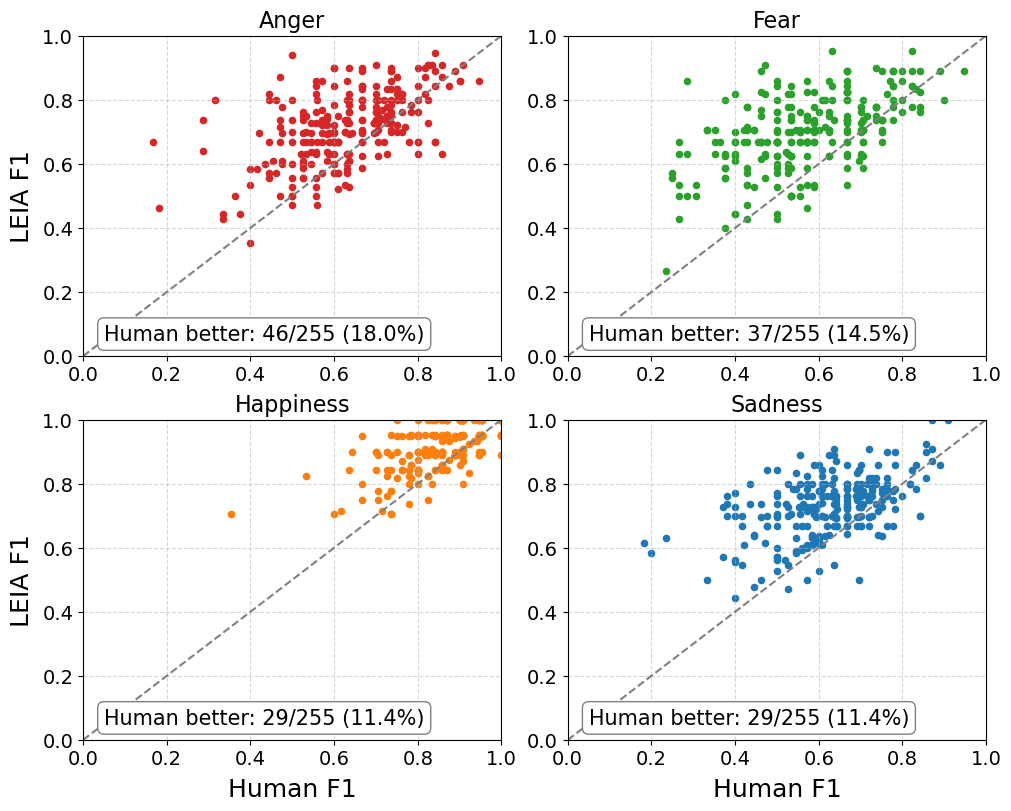

In [42]:
# fixed 4-colour palette
emotion_palette = ['#d62728',  # red
                   '#2ca02c',  # green
                   '#ff7f0e',  # orange
                   '#1f77b4']  # blue

emotion_colors = dict(zip(emotions, emotion_palette))
print(emotion_colors)

def scatter_paired_emotions(df, s=20, alpha=1, base_fs=18, tick_fs=14, text_fs=15):    
    """Create a paired scatter plot of F1_score per emotion for LEIA and Humans. 

    Args:
        df (dataframe): metrics per annotator
        s (int, optional): size of dots. Defaults to 20.
        alpha (int, optional): color fill value. Defaults to 1.
        base_fs (int, optional): adaptive fontisze. Defaults to 18.
        tick_fs (int, optional): tick fontsize. Defaults to 14.
        text_fs (int, optional): text fontsize. Defaults to 15.
        
    Retruns:
        plot and saves it as a pdf
    """

    fig, axes = plt.subplots(2, 2, figsize=(10, 8),  
                             constrained_layout=True)
    axes = axes.flatten()                             
    for i, (emotion, ax) in enumerate(zip(emotions, axes)):
        emotion_df = df[df['Emotion'] == emotion]

        # scatter points
        ax.scatter(emotion_df['F1-score'],
                   emotion_df['Leia_F1'],
                   alpha=alpha, s=s, color=emotion_colors[emotion] )  
        ax.plot([0, 1], [0, 1], ls='--', color='gray')

        # annotation: Human better count / %
        better = (emotion_df['F1-score'] > emotion_df['Leia_F1']).sum()
        total  = len(emotion_df)
        pct    = 100 * better / total
        ax.annotate(f'Human better: {better}/{total} ({pct:.1f}%)',
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    fontsize=text_fs,
                    bbox=dict(boxstyle='round,pad=0.30',
                              facecolor='white', edgecolor='gray'))

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, ls='--', alpha=.5)
        ax.tick_params(axis='both', labelsize=tick_fs)

        ax.set_title(emotion, fontsize=text_fs+1, pad=6)

        # label logic 
        row, col = divmod(i, 2)  

        if col == 0:                            
            ax.set_ylabel('LEIA F1', fontsize=base_fs, labelpad=6)
        else:                                    
            ax.set_ylabel('')

        if row == 1:                              
            ax.set_xlabel('Human F1', fontsize=base_fs, labelpad=6)
        else:                                     
            ax.set_xlabel('')


    # save & display
    fig.savefig(f"../images/exp2-paired-scatter_emot-{type}.pdf",
                bbox_inches="tight", dpi=300)
    plt.show()


scatter_paired_emotions(metrics_per_annotator, 'all')


In [43]:
metrics_per_annotator_leia[metrics_per_annotator_leia['Emotion']=="Happiness"]['F1-score'].nunique()

16

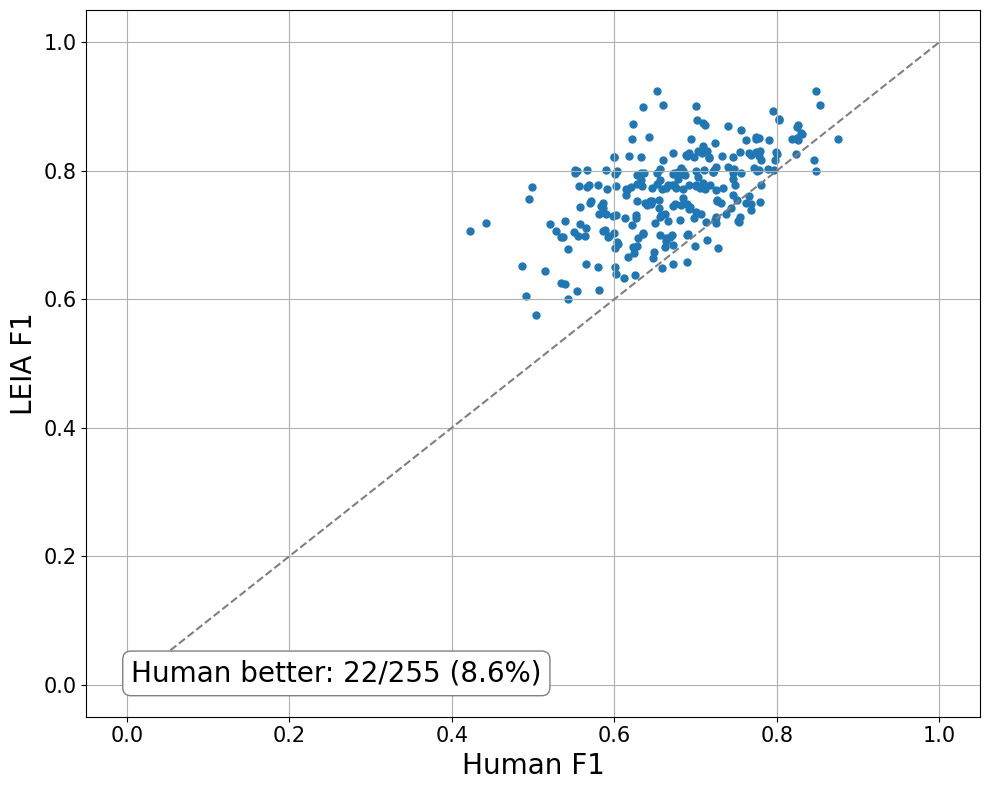

In [44]:


def scatter_paired(user_f1, Leia_F1, s=15, alpha=1):

    """Create a paired scatter plot of F1_score for LEIA and Humans. 

    Args:
        user_f1 (list): Human macro_f1 column per annotator sample
        Leia_F1 (list): LEIA macro_f1 column per annotator sample
        s (int, optional): size of dots. Defaults to 15.
        alpha (int, optional): color fill value. Defaults to 1.
       
    """

    plt.figure(figsize=(10, 8))
    plt.scatter(user_f1, Leia_F1, alpha=alpha, s=s, color='#1f77b4')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    
    better_count = sum(np.array(user_f1) > np.array(Leia_F1))
    total = len(user_f1)
    percentage = better_count / total * 100
    
    # Annotate the result
    plt.annotate(f'Human better: {better_count}/{total} ({percentage:.1f}%)',
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    fontsize=20,
                    bbox=dict(boxstyle='round,pad=0.30',
                              facecolor='white', edgecolor='gray'))

    plt.xlabel("Human F1", fontsize = 20)
    plt.ylabel("LEIA F1", fontsize = 20)

    plt.tick_params(labelsize=15)
    plt.grid(True)

    plt.savefig("../images/exp1-paired-scatter.pdf",
                bbox_inches="tight", dpi=300)
    plt.show()


scatter_paired(macro_f1_anno['Macro F1-score'], macro_f1_anno['Leia Macro'], 'LEIA vs Participants paired Macro F1-scores', 25)


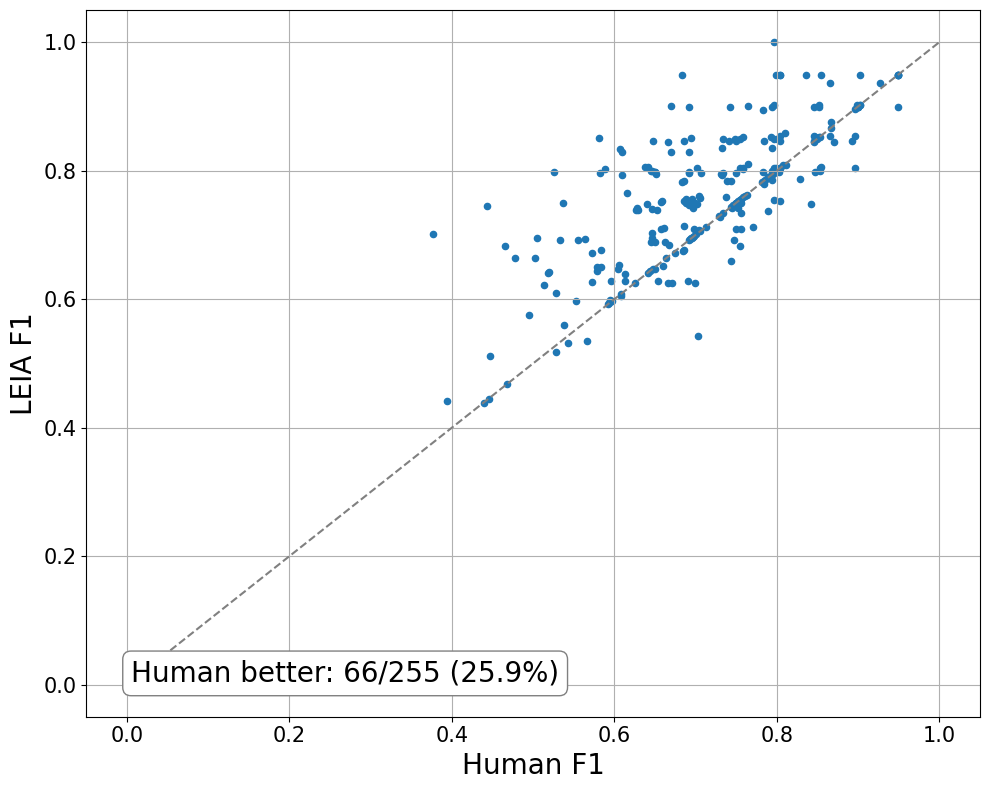

In [45]:
scatter_paired(macro_f1_anno_leia['Macro F1-score'], macro_f1_anno_leia['Leia Macro'], 'LEIA vs Participants paired Macro F1-scores', 20)

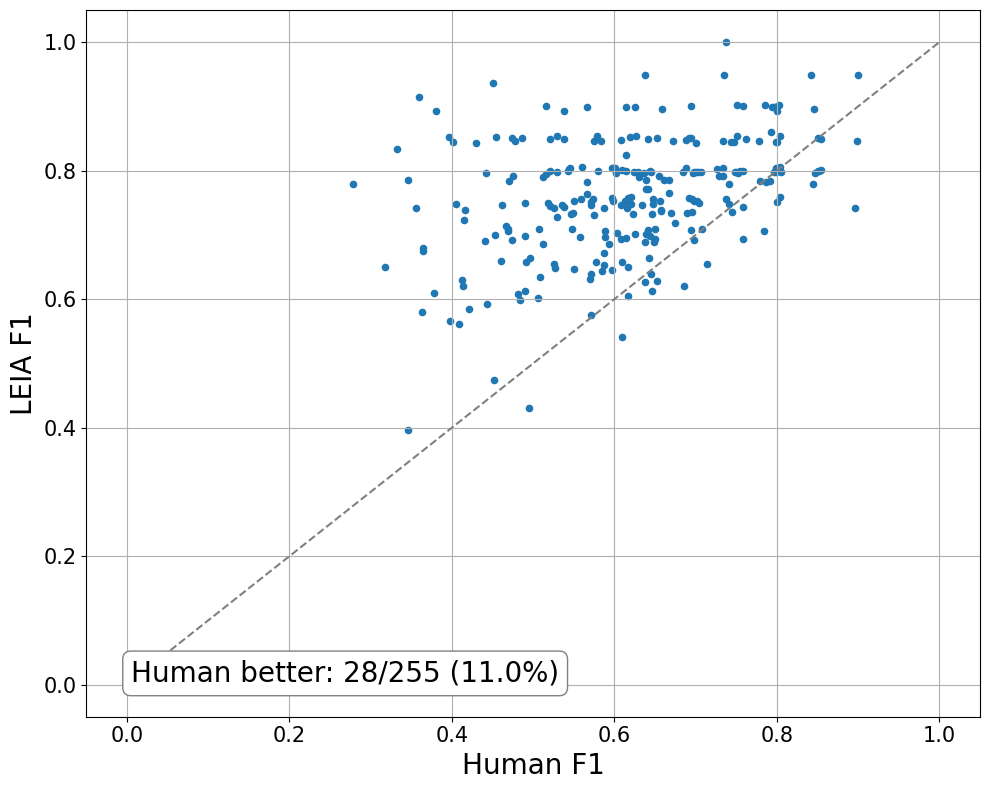

In [46]:
scatter_paired(macro_f1_anno_no_leia['Macro F1-score'], macro_f1_anno_no_leia['Leia Macro'], 'LEIA vs Participants paired Macro F1-scores', 20)

In [47]:
def scatter_paired_dual(user_f1_a, leia_f1_a, user_f1_b, leia_f1_b,
                        title_a="With LEIA", title_b="Without LEIA", s=20, alpha=1):
    
    """Plot the paried scatterplots of both conditions next to each other
    """

    fig, axes = plt.subplots(1, 2, figsize=(16, 7),  sharey=True)

    for ax, user_f1, leia_f1, title in zip(
        axes,
        [user_f1_a, user_f1_b],
        [leia_f1_a, leia_f1_b],
        [title_a, title_b]
    ):
        ax.scatter(user_f1, leia_f1, alpha=alpha, s=s, color='#1f77b4')
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

        # Calculate performance comparison
        better_count = sum(np.array(user_f1) > np.array(leia_f1))
        total = len(user_f1)
        percentage = better_count / total * 100

        ax.annotate(f'Human better: {better_count}/{total} ({percentage:.1f}%)',
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    fontsize=20,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray'))

        ax.set_title(title, fontsize=20)
        ax.set_xlabel("Human F1", fontsize=20)
        ax.set_ylabel("LEIA F1", fontsize=20)
        ax.tick_params(labelsize=15)
        ax.grid(True)

    plt.tight_layout()
    plt.savefig("../images/exp2-paired-scatter-comparison.pdf", bbox_inches="tight", dpi=300)
    plt.show()


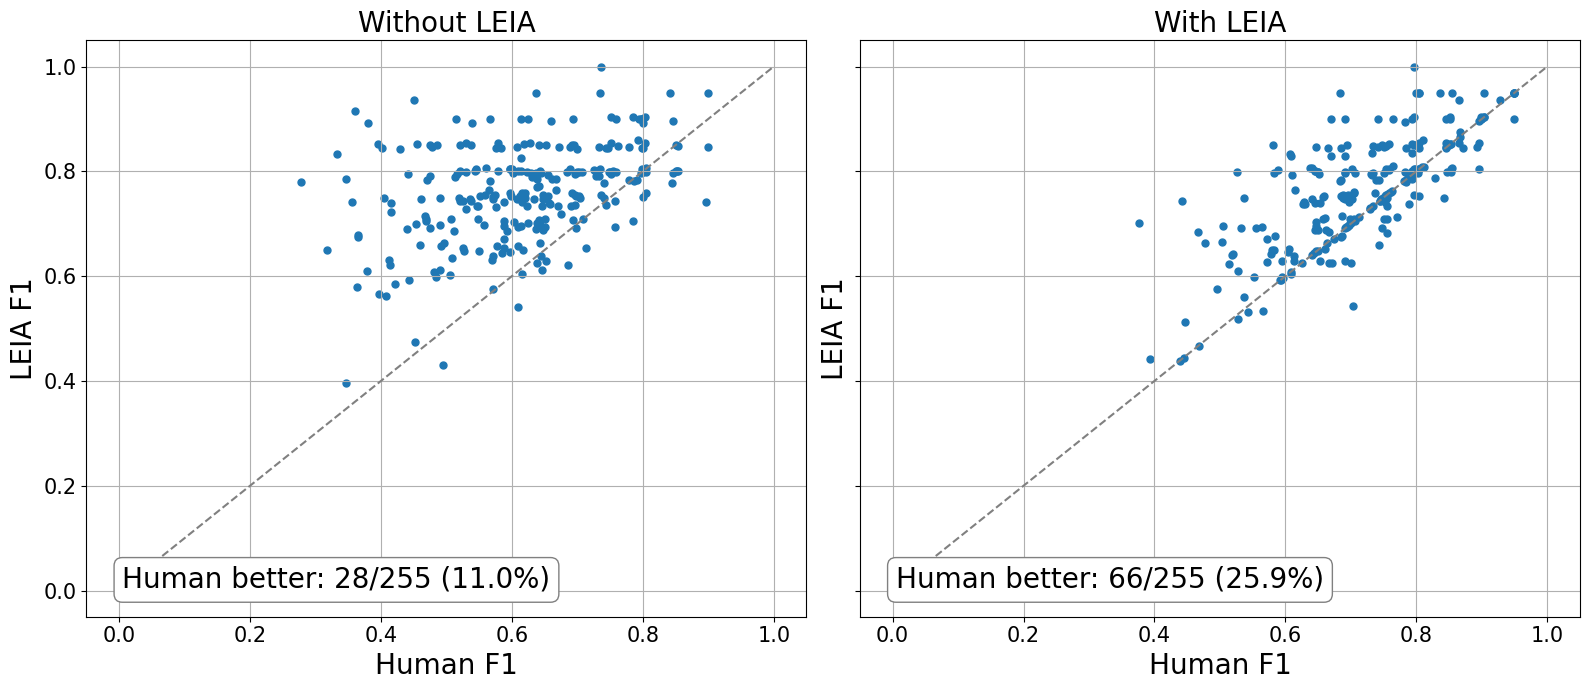

In [48]:
scatter_paired_dual(macro_f1_anno_no_leia['Macro F1-score'], macro_f1_anno_no_leia['Leia Macro'],
    macro_f1_anno_leia['Macro F1-score'], macro_f1_anno_leia['Leia Macro'],
    title_b="With LEIA",
    title_a="Without LEIA",
    s=25
)


In [49]:
macro_f1_anno['Difference'] = macro_f1_anno['Macro F1-score'] - macro_f1_anno['Leia Macro']

In [50]:
better_count = len(macro_f1_anno[macro_f1_anno['Difference']>0])
better_count

22

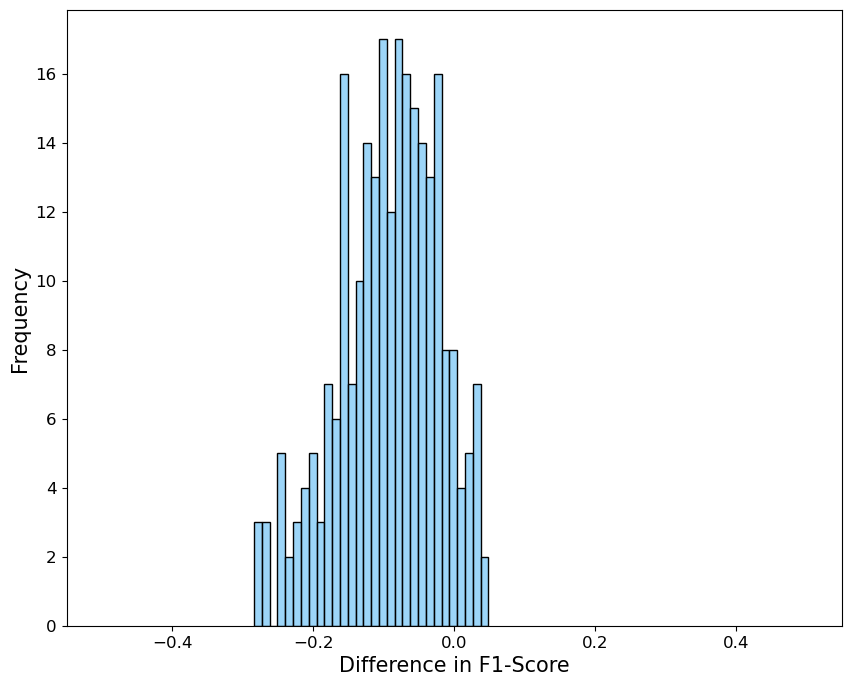

In [51]:
macro_f1_anno['Difference'] = macro_f1_anno['Macro F1-score'] - macro_f1_anno['Leia Macro']


plt.figure(figsize=(10, 8))

sns.histplot(macro_f1_anno['Difference'], bins=30, color='#7bc8f6')

plt.ylabel("Frequency", fontsize=15)
plt.tick_params(labelsize = 12)
plt.xlim(-0.55, 0.55)
plt.xlabel("Difference in F1-Score", fontsize=15)
plt.savefig("../images/diff_in_f1_exp2-all.pdf",
                bbox_inches="tight", dpi=300)
plt.show()



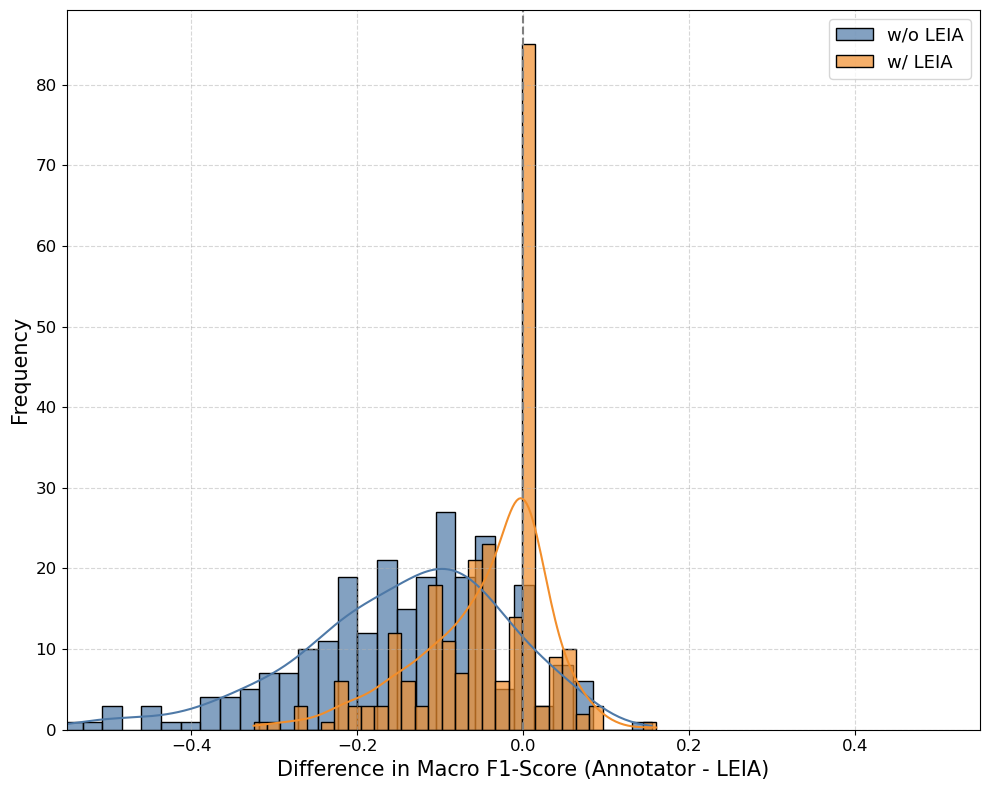

In [52]:

macro_f1_anno_no_leia['Difference'] = macro_f1_anno_no_leia['Macro F1-score'] - macro_f1_anno_no_leia['Leia Macro']
macro_f1_anno_leia['Difference'] = macro_f1_anno_leia['Macro F1-score'] - macro_f1_anno_leia['Leia Macro']

# Plot both in one figure
plt.figure(figsize=(10, 8))

sns.histplot(macro_f1_anno_no_leia['Difference'], bins=30, color='#4e79a7',
             label='w/o LEIA', alpha=0.7, kde=True)
sns.histplot(macro_f1_anno_leia['Difference'], bins=30, color='#f28e2b',
             label='w/ LEIA', alpha=0.7, kde=True)

plt.axvline(0, linestyle='--', color='gray')
plt.xlim(-0.55, 0.55)
plt.xlabel("Difference in Macro F1-Score (Annotator - LEIA)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.tick_params(labelsize=12)
plt.legend(title='', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("../images/diff_in_f1_exp2-combined.pdf", bbox_inches="tight", dpi=300)
plt.show()


In [53]:

metrics_per_annotator_leia = metrics_per_annotator_leia.copy()
metrics_per_annotator_no_leia = metrics_per_annotator_no_leia.copy()

metrics_per_annotator_leia['Condition'] = 'w/ LEIA'
metrics_per_annotator_no_leia['Condition'] = 'w/o LEIA'

combined = pd.concat([metrics_per_annotator_leia, metrics_per_annotator_no_leia], ignore_index=True)

# Compute difference per emotion
combined['F1_Diff'] = combined['F1-score'] - combined['Leia_F1']

# Emotion order
emotions = ['Anger', 'Fear', 'Happiness', 'Sadness']
condition_palette = {
    'w/ LEIA': '#ff7f0e',      # orange
    'w/o LEIA': '#1f77b4'      # blue
}


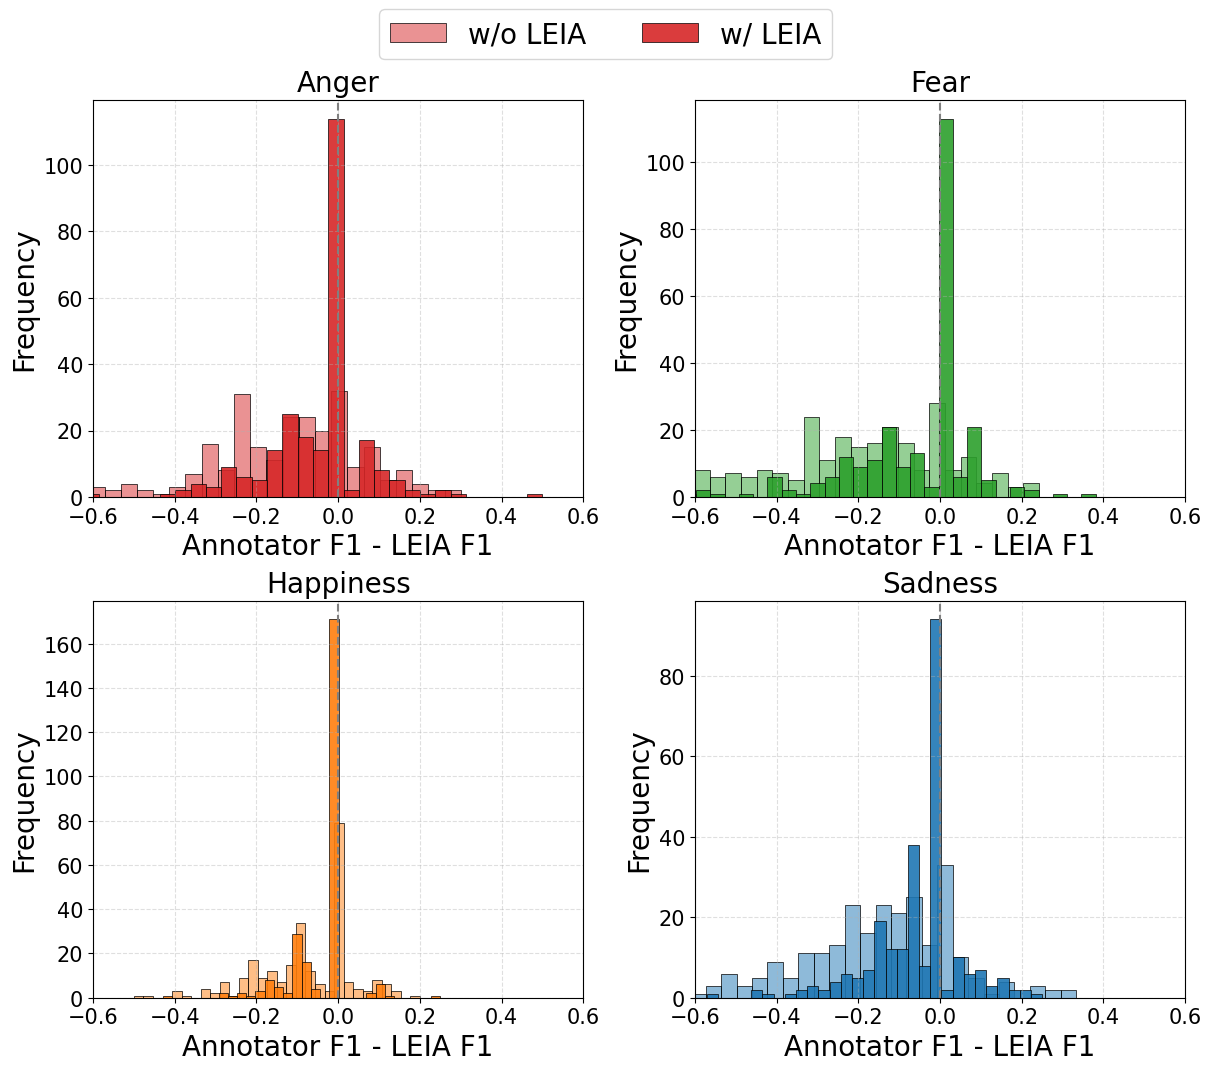

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)
axes = axes.flatten()

for i, emotion in enumerate(emotions):
    ax = axes[i]
    emo_data = combined[combined['Emotion'] == emotion]

    for condition, style in zip(['w/o LEIA', 'w/ LEIA'], ['/', '\\']):
        cond_data = emo_data[emo_data['Condition'] == condition]

        sns.histplot(
            cond_data['F1_Diff'],
            bins=30,
            kde=False,
            ax=ax,
            label=condition,
            color=emotion_colors[emotion],
            alpha=0.5 if condition == 'w/o LEIA' else 0.9,
            linewidth=0.5,
            edgecolor='black'
        )



    ax.axvline(0, ls='--', color='gray')
    ax.set_title(emotion, fontsize=20)
    ax.set_xlim(-0.6, 0.6)
    ax.set_xlabel("Annotator F1 - LEIA F1", fontsize=20)
    ax.set_ylabel("Frequency", fontsize=20)
    ax.tick_params(labelsize=15)
    ax.grid(True, ls='--', alpha=0.4)

# Legend on top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='', loc='upper center',
           bbox_to_anchor=(0.5, 1.07), ncol=2, fontsize=20)

plt.savefig("../images/emotionwise_diff_f1_exp2.pdf", bbox_inches='tight', dpi=300)
plt.show()


## Metrics without differentiating between individuals

In [49]:
annotator_df_no_leia, annotator_df_leia = split_by_type(annotator_df)

In [50]:
def metrics(df, label):
    """Compute precision, recall, F1-score, and support for each emotion, along with macro averages.

    Args: 
        df: Dataframe with annotator as rows
        label_col: column containing predicted values
    Returns:
        per emotion dataframe, macro results and accuracy
    """
    metrics = {}
    emotions = df['true_label'].unique()

    acc = accuracy(df, 'true_label', label)

    for emotion in emotions:
        metrics[emotion] = {
            'precision': round(precision(df, 'true_label', emotion, label), 3),
            'recall': round(recall(df, 'true_label', emotion, label), 3),
            'f1_score': round(own_f1_score(df, 'true_label', emotion, label), 3)
        }

    prec_rc_f1 = pd.DataFrame.from_dict(metrics, orient='index')

    macro_f1 = prec_rc_f1['f1_score'].mean()
    
    macro_prec = prec_rc_f1['precision'].mean()
    macro_rec = prec_rc_f1['recall'].mean()

    macro_row = pd.DataFrame({
        'precision': [macro_prec],
        'recall': [macro_rec],
        'f1_score': [macro_f1]
    }, index=['Macro Average'])
    
    # Concatenate and reindex
    prec_rc_f1 = pd.concat([macro_row, prec_rc_f1])

    return prec_rc_f1, macro_f1, acc

annotator_per_emot, annotator_macro_f1, annotator_acc = metrics(annotator_df, 'label')


leia_per_emot, leia_macro_f1, leia_acc = metrics(annotator_df, 'Leia_Label')
leia_per_emot, annotator_per_emot


(               precision  recall  f1_score
 Macro Average      0.773   0.766    0.7665
 Anger              0.690   0.748    0.7180
 Sadness            0.681   0.776    0.7250
 Fear               0.780   0.640    0.7030
 Happiness          0.941   0.900    0.9200,
                precision   recall  f1_score
 Macro Average      0.686  0.67725    0.6745
 Anger              0.627  0.64000    0.6330
 Sadness            0.559  0.70400    0.6230
 Fear               0.707  0.49100    0.5800
 Happiness          0.851  0.87400    0.8620)

In [51]:
annotator_per_emot_no_leia, annotator_macro_f1_no_leia, annotator_acc_no_leia = metrics(annotator_df_no_leia, 'label')


leia_per_emot_no_leia, leia_macro_f1_no_leia, leia_acc_no_leia = metrics(annotator_df_no_leia, 'Leia_Label')
leia_per_emot_no_leia, annotator_per_emot_no_leia

(               precision  recall  f1_score
 Macro Average      0.773   0.766    0.7665
 Anger              0.690   0.748    0.7180
 Sadness            0.681   0.776    0.7250
 Fear               0.780   0.640    0.7030
 Happiness          0.941   0.900    0.9200,
                precision   recall  f1_score
 Macro Average    0.64175  0.63325   0.62875
 Anger            0.59500  0.58700   0.59100
 Sadness          0.50600  0.65800   0.57200
 Fear             0.65300  0.42300   0.51400
 Happiness        0.81300  0.86500   0.83800)

In [52]:
annotator_per_emot_leia, annotator_macro_f1_leia, annotator_acc_leia = metrics(annotator_df_leia, 'label')


leia_per_emot_leia, leia_macro_f1_leia, leia_acc_leia = metrics(annotator_df_leia, 'Leia_Label')
leia_per_emot_leia, annotator_per_emot_leia

(               precision  recall  f1_score
 Macro Average      0.773   0.766    0.7665
 Sadness            0.681   0.776    0.7250
 Anger              0.690   0.748    0.7180
 Fear               0.780   0.640    0.7030
 Happiness          0.941   0.900    0.9200,
                precision  recall  f1_score
 Macro Average    0.72975  0.7205   0.71975
 Sadness          0.61600  0.7490   0.67600
 Anger            0.65600  0.6920   0.67400
 Fear             0.75500  0.5590   0.64200
 Happiness        0.89200  0.8820   0.88700)

In [53]:
leia_acc, annotator_acc

(0.766, 0.677)

In [54]:
anno_maj_aggr_emot_no_leia, anno_maj_aggr_emot_leia = split_by_type(anno_maj_aggr_emot)

In [55]:
anno_maj_per_emot, anno_maj_macro_f1, anno_maj_acc = metrics(anno_maj_aggr_emot, 'annotator_majority')

anno_maj_per_emot


,precision,recall,f1_score
Macro Average,0.72875,0.716,0.714
Sadness,0.59800,0.762,0.670
Anger,0.66000,0.682,0.671
Fear,0.77000,0.528,0.626
Happiness,0.88700,0.892,0.889


In [56]:
anno_maj_per_emot_no_leia, anno_maj_macro_f1_no_leia, anno_maj_acc_no_leia = metrics(anno_maj_aggr_emot_no_leia, 'annotator_majority')

anno_maj_per_emot_no_leia


,precision,recall,f1_score
Macro Average,0.6985,0.681,0.6775
Sadness,0.5410,0.736,0.6240
Anger,0.6460,0.636,0.6410
Fear,0.7530,0.464,0.5740
Happiness,0.8540,0.888,0.8710


In [57]:
anno_maj_per_emot_leia, anno_maj_macro_f1_leia, anno_maj_acc_leia = metrics(anno_maj_aggr_emot_leia, 'annotator_majority')

anno_maj_per_emot_leia


,precision,recall,f1_score
Macro Average,0.760,0.751,0.7505
Sadness,0.663,0.788,0.7200
Anger,0.672,0.728,0.6990
Fear,0.783,0.592,0.6740
Happiness,0.922,0.896,0.9090


In [65]:

metrics_dict = {
    "Annotators (no LEIA)": annotator_per_emot_no_leia,
    "Majority (no LEIA)": anno_maj_per_emot_no_leia,
    "Annotators (with LEIA)": annotator_per_emot_leia,
    "Majority (with LEIA)": anno_maj_per_emot_leia,
    "LEIA": leia_per_emot
}

for key, value in metrics_dict.items():

    metrics_dict[key] = value.reset_index().rename(columns={'index': 'emotion'})


In [66]:
metrics_dict

{'Annotators (no LEIA)':          emotion  precision   recall  f1_score
 0  Macro Average    0.64175  0.63325   0.62875
 1          Anger    0.59500  0.58700   0.59100
 2        Sadness    0.50600  0.65800   0.57200
 3           Fear    0.65300  0.42300   0.51400
 4      Happiness    0.81300  0.86500   0.83800,
 'Majority (no LEIA)':          emotion  precision  recall  f1_score
 0  Macro Average     0.6985   0.681    0.6775
 1        Sadness     0.5410   0.736    0.6240
 2          Anger     0.6460   0.636    0.6410
 3           Fear     0.7530   0.464    0.5740
 4      Happiness     0.8540   0.888    0.8710,
 'Annotators (with LEIA)':          emotion  precision  recall  f1_score
 0  Macro Average    0.72975  0.7205   0.71975
 1        Sadness    0.61600  0.7490   0.67600
 2          Anger    0.65600  0.6920   0.67400
 3           Fear    0.75500  0.5590   0.64200
 4      Happiness    0.89200  0.8820   0.88700,
 'Majority (with LEIA)':          emotion  precision  recall  f1_score
 0

In [67]:
diff_groupings_dfs = {"Annotators (no LEIA)": [annotator_df_no_leia, 'label'],
    "Majority (no LEIA)": [anno_maj_aggr_emot_no_leia, 'annotator_majority'],
    "Annotators (with LEIA)": [annotator_df_leia, 'label'],
    "Majority (with LEIA)":[ anno_maj_aggr_emot_leia, 'annotator_majority'],
    "LEIA": [annotator_df, 'Leia_Label']}

In [68]:

def bootstrap_f1_scores(diff_groupings_dfs, emotions, boot_n=1000):
    """
    Bootstraps macro and per-emotion F1 scores for grouped model/human predictions.

    Parameters:
        diff_groupings_dfs (dict): Mapping from model type to (DataFrame, label_col) tuple.
        emotions (list): List of emotion labels to evaluate.
        boot_n (int): Number of bootstrap samples.

    Returns:
        macro_boot_results (dict): Summary stats (mean, lower, upper) of macro F1 per type.
        per_emotion_boot_results (dict): Summary stats (mean, lower, upper) per emotion per type.
        macro_boot_distributions (dict): Full list of macro F1 scores per type.
        per_emotion_boot_distributions (dict): Full list of F1 scores per emotion per type.
    """
    macro_boot_results = {}
    per_emotion_boot_results = {}
    macro_boot_distributions = {}
    per_emotion_boot_distributions = {}

    for group_type, (df, label_col) in tqdm(diff_groupings_dfs.items(), desc="Bootstrapping groups"):
        df = df.copy()
        macro_scores = []
        emotion_scores = {e: [] for e in emotions}

        for _ in tqdm(range(boot_n), desc=f"Bootstrapping {group_type}"):
            boot_df = df.sample(frac=1, replace=True)

            try:
                # Macro F1
                macro = f1_score(boot_df['true_label'], boot_df[label_col], average='macro')
                macro_scores.append(macro)

                # Per-emotion F1
                for emotion in emotions:
                    y_true = (boot_df['true_label'] == emotion).astype(int)
                    y_pred = (boot_df[label_col] == emotion).astype(int)

                    if y_true.sum() > 0:
                        emo_f1 = f1_score(y_true, y_pred)
                        emotion_scores[emotion].append(emo_f1)

            except Exception:
                continue

        # Store macro results
        macro_boot_results[group_type] = {
            "mean": np.mean(macro_scores),
            "lower": np.percentile(macro_scores, 2.5),
            "upper": np.percentile(macro_scores, 97.5)
        }
        macro_boot_distributions[group_type] = macro_scores

        # Store per-emotion results
        per_emotion_boot_results[group_type] = {}
        per_emotion_boot_distributions[group_type] = {}

        for emotion, scores in emotion_scores.items():
            per_emotion_boot_results[group_type][emotion] = {
                "mean": np.mean(scores),
                "lower": np.percentile(scores, 2.5),
                "upper": np.percentile(scores, 97.5)
            }
            per_emotion_boot_distributions[group_type][emotion] = scores

    return macro_boot_results, per_emotion_boot_results, macro_boot_distributions, per_emotion_boot_distributions


In [69]:

macro_boot_results, per_emotion_boot_results, macro_boot_distributions, per_emotion_boot_distributions= bootstrap_f1_scores(
diff_groupings_dfs,
emotions=emotions,
boot_n=1000,
)


Bootstrapping groups: 100%|██████████| 5/5 [15:23<00:00, 184.77s/it]


In [70]:
macro_boot_results

{'Annotators (no LEIA)': {'mean': 0.6287211997009627,
  'lower': 0.6151561565821687,
  'upper': 0.6417209371859217},
 'Majority (no LEIA)': {'mean': 0.6770064463804033,
  'lower': 0.6481378376763485,
  'upper': 0.7061441829904032},
 'Annotators (with LEIA)': {'mean': 0.7196434735739065,
  'lower': 0.707197128823325,
  'upper': 0.7316085605077832},
 'Majority (with LEIA)': {'mean': 0.7495971356894531,
  'lower': 0.7207418745037012,
  'upper': 0.7757294186896417},
 'LEIA': {'mean': 0.7664770490131562,
  'lower': 0.7580763992730308,
  'upper': 0.7744136665236626}}

In [71]:

group_order = {
    "Humans - w/o LEIA": ["Annotators (no LEIA)", "Majority (no LEIA)"],
    "Humans - w/ LEIA": ["Annotators (with LEIA)", "Majority (with LEIA)"],
    "Leia": ["LEIA"]}


group_base_colors = {
    "Humans - w/o LEIA":'#1f77b4', 
    "Humans - w/ LEIA":'#98df8a',      # blue
    'Leia': '#ffa500'}      # gold




In [72]:
def generate_similar_colors(base_hex, n):
    """Generate `n` visually distinct but similar colors from a base hex color."""
    base_rgb = mcolors.to_rgb(base_hex)
    base_hls = colorsys.rgb_to_hls(*base_rgb)

    colors = []
    for i in range(n):
        # Shift hue slightly to generate variations (±0.05 per step)
        hue_shift = (i - n // 2) * 0.08
        new_hue = (base_hls[0] + hue_shift) % 1.0
        # Keep lightness and saturation the same
        new_rgb = colorsys.hls_to_rgb(new_hue, base_hls[1], base_hls[2])
        colors.append(new_rgb)
    return colors

model_colors = {}

for group, readable_names in group_order.items():
    base_color = group_base_colors[group]
    n = len(readable_names)
    
    similar_colors = generate_similar_colors(base_color, n)
    for name, color in zip(readable_names, similar_colors):
        model_colors[name] = color


In [73]:
# Extract macro_f1s and error bars from bootstrapping results
macro_f1s = {model: macro_boot_results[model] for model in macro_boot_results}

positions = []
labels = []
colors = []
f1_scores = []
yerr_lower = []
yerr_upper = []

current_x = 0
gap = 0.5  # space between groups

for group, models in group_order.items():
    for model in models:
        if model in macro_f1s:  # skip missing models
            score = macro_f1s[model]["mean"]
            lower = macro_f1s[model]["lower"]
            upper = macro_f1s[model]["upper"]

            positions.append(current_x)
            labels.append(model)
            colors.append(model_colors[model])
            f1_scores.append(score)
            yerr_lower.append(score - lower)
            yerr_upper.append(upper - score)
            current_x += 1
    current_x += gap


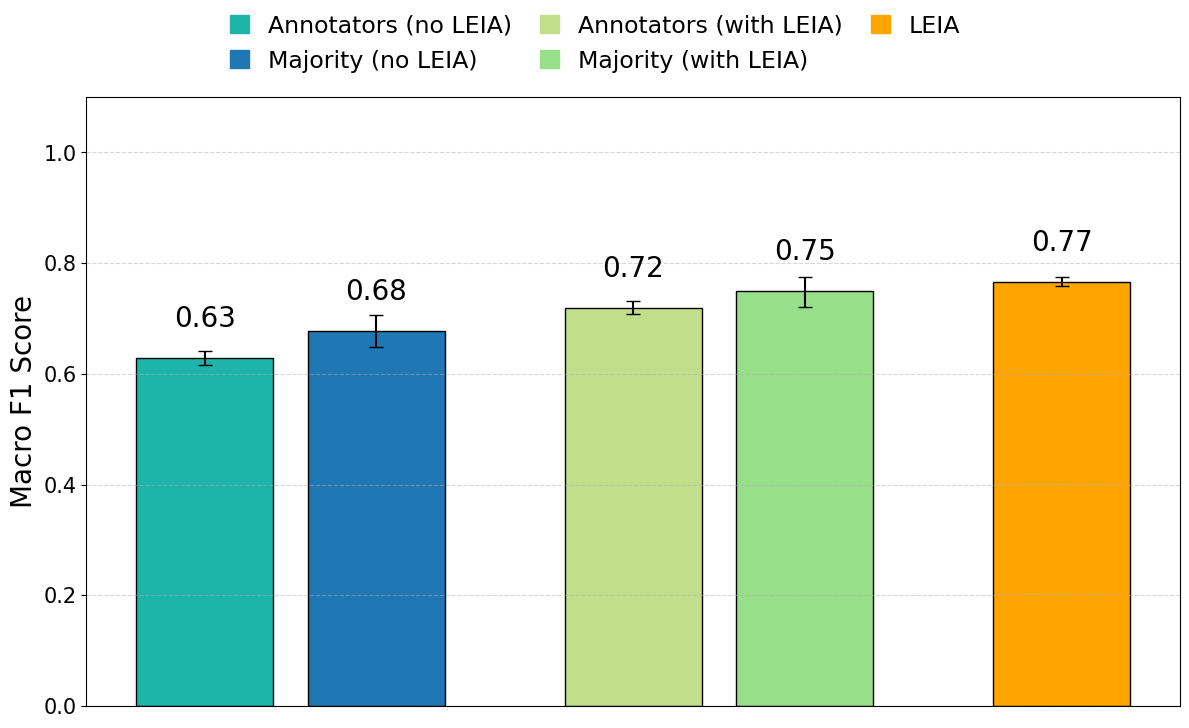

In [74]:
fig, ax = plt.subplots(figsize=(12, 7))

bars = ax.bar(
    positions,
    f1_scores,
    yerr=[yerr_lower, yerr_upper],
    color=colors,
    edgecolor="black",
    capsize=5
)

for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            h + 0.045, f"{h:.2f}",
            ha="center", va="bottom", fontsize=20)

ax.set_xticks([])  
ax.set_ylabel("Macro F1 Score", fontsize=20)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.tick_params(labelsize = 15)

n_labels = len(labels)
n_cols = math.ceil(n_labels / 2)
handles = [mpatches.Patch(color=model_colors[m], label=m) for m in labels]

fig.legend(handles=handles,
           loc="upper center",
           bbox_to_anchor=(0.5, 1.05),   
           ncol=n_cols,
           frameon=False,
           handlelength=0.8, handleheight=0.8,
           columnspacing=1.2, borderpad=0.2,
           fontsize=17)

fig.tight_layout(rect=[0, 0, 1, 0.93])  
fig.savefig("../images/macro_f1_annot_type.pdf", bbox_inches="tight")
plt.show()


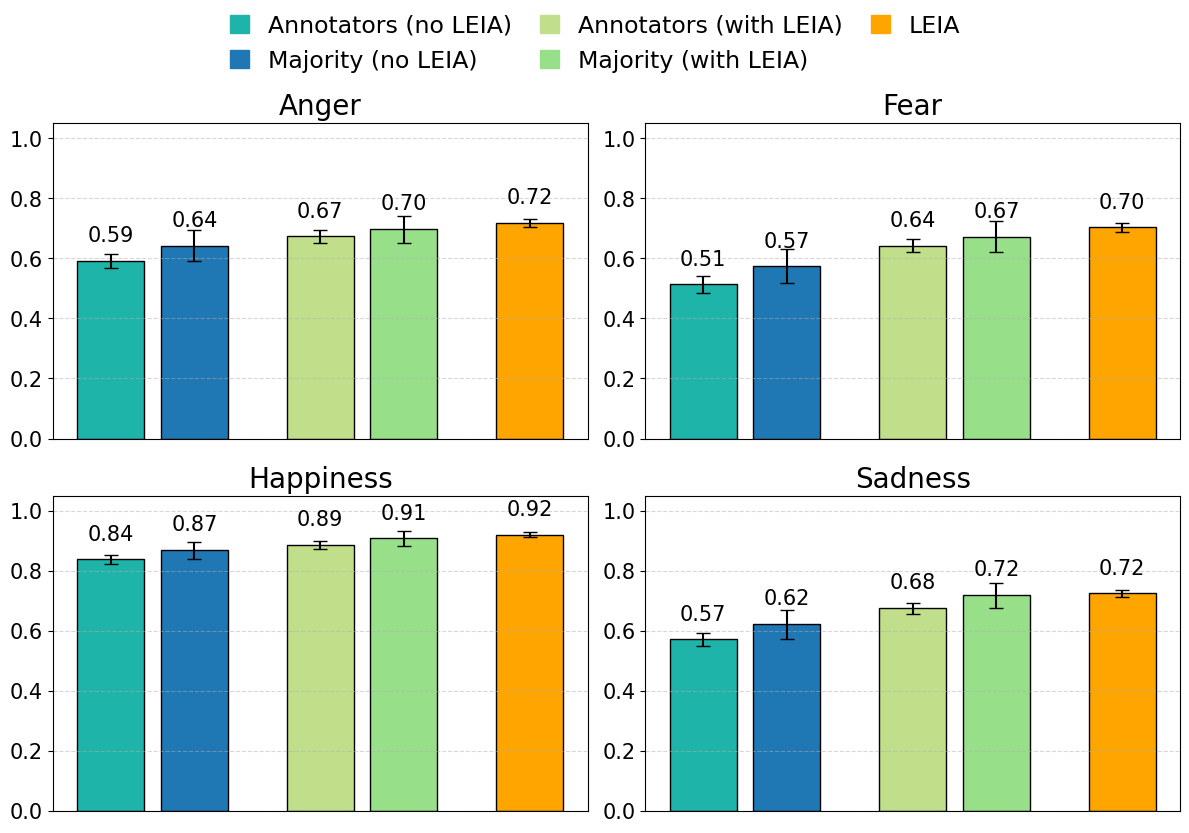

In [75]:
emotions = ["Anger", "Fear", "Happiness", "Sadness"]

# Create grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  
axes = axes.flatten()

for idx, emotion in enumerate(emotions):
    ax = axes[idx]

    positions = []
    labels = []
    colors = []
    f1_scores = []
    yerr_lower = []
    yerr_upper = []

    current_x = 0
    gap = 0.5  # Gap between model groups

    for group, models in group_order.items():
        for model in models:
            if model in per_emotion_boot_results and emotion in per_emotion_boot_results[model]:
                stats = per_emotion_boot_results[model][emotion]
                score = stats["mean"]
                lower = stats["lower"]
                upper = stats["upper"]

                positions.append(current_x)
                labels.append(model)
                colors.append(model_colors.get(model, "gray"))
                f1_scores.append(score)
                yerr_lower.append(score - lower)
                yerr_upper.append(upper - score)
                current_x += 1
        current_x += gap

    # Plot bars with error bars
    bars = ax.bar(
        positions,
        f1_scores,
        yerr=[yerr_lower, yerr_upper],
        color=colors,
        edgecolor="black",
        capsize=5
    )

    # Add value labels
    for pos, score in zip(positions, f1_scores):
       ax.text(pos, score + 0.05, f"{score:.2f}", ha='center', va='bottom', fontsize=15)

    # Style the axes
    ax.set_xticks([])
    ax.set_ylim(0, 1.05)
    ax.set_title(emotion, fontsize=20)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=15)

unique_labels = list(dict.fromkeys(labels)) 
n_cols = math.ceil(len(unique_labels) / 2)

legend_handles = [mpatches.Patch(color=model_colors[m], label=m) for m in unique_labels]
fig.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=n_cols,
    frameon=False,
    handlelength=0.8,
    handleheight=0.8,
    columnspacing=1.2,
    borderpad=0.2,
    fontsize=17
)

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("../images/per_emotion_f1_bootstrapped_per_type.pdf", bbox_inches="tight")
plt.show()

In [76]:
def macro_f1_dist_all_models(data_dict, model_colors, fontsize=20):
    """
    Plots Macro F1 in top row center and each emotion in a 2x2 grid,
    showing all models with color-coded distributions.
    """
    emotion_items = [item for item in data_dict.items() if item[0] != "Macro"]

    fig = plt.figure(constrained_layout=True, figsize=(18, 13))
    gs = fig.add_gridspec(3, 4)  # 3 rows x 4 columns layout

    # --- Macro plot ---
    ax_macro = fig.add_subplot(gs[0, 1:3])
    for model_name, f1_list in data_dict["Macro"].items():
        sns.histplot(f1_list, kde=True, bins=20, label=model_name,
                     color=model_colors.get(model_name, 'gray'), ax=ax_macro)
    ax_macro.set_title("Macro F1-score", fontsize=fontsize)
    ax_macro.set_xlim(0.45, 1)
    ax_macro.set_xlabel("F1-score", fontsize=fontsize - 2)
    ax_macro.set_ylabel("Frequency", fontsize=fontsize - 2)
    ax_macro.tick_params(labelsize=fontsize - 5)
    ax_macro.grid(True)

    # --- Emotion plots in 2x2 layout ---
    positions = [(1, 0), (1, 2), (2, 0), (2, 2)]
    for ((emotion, model_dict), (r, c)) in zip(emotion_items, positions):
        ax = fig.add_subplot(gs[r, c:c+2])
        for model_name, f1_list in model_dict.items():
            sns.histplot(f1_list, kde=True, bins=20, label=model_name,
                         color=model_colors.get(model_name, 'gray'), ax=ax)
        ax.set_title(f"{emotion}", fontsize=fontsize)
        ax.set_xlim(0.45, 1)

        if r == 2:
            ax.set_xlabel("F1-score", fontsize=fontsize - 2)
        else:
            ax.set_xlabel("")
            ax.set_xticklabels([])

        if c == 0:
            ax.set_ylabel("Frequency", fontsize=fontsize - 2)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])

        ax.tick_params(labelsize=fontsize - 5)
        ax.grid(True)

    handles, labels = ax_macro.get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc='upper right',
        bbox_to_anchor=(0.98, 0.98),
        fontsize=fontsize,
        frameon=False
    )

    fig.savefig(f"../images/exp2-distribution_bootstrapped_f1-all.pdf", bbox_inches="tight")
    plt.show()


In [77]:
# Build the full data_dict dynamically
data_dict = {"Macro": {}}
for model_name in macro_boot_distributions:
    data_dict["Macro"][model_name] = macro_boot_distributions[model_name]

for emotion in emotions:
    data_dict[emotion] = {}
    for model_name in per_emotion_boot_distributions:
        data_dict[emotion][model_name] = per_emotion_boot_distributions[model_name][emotion]


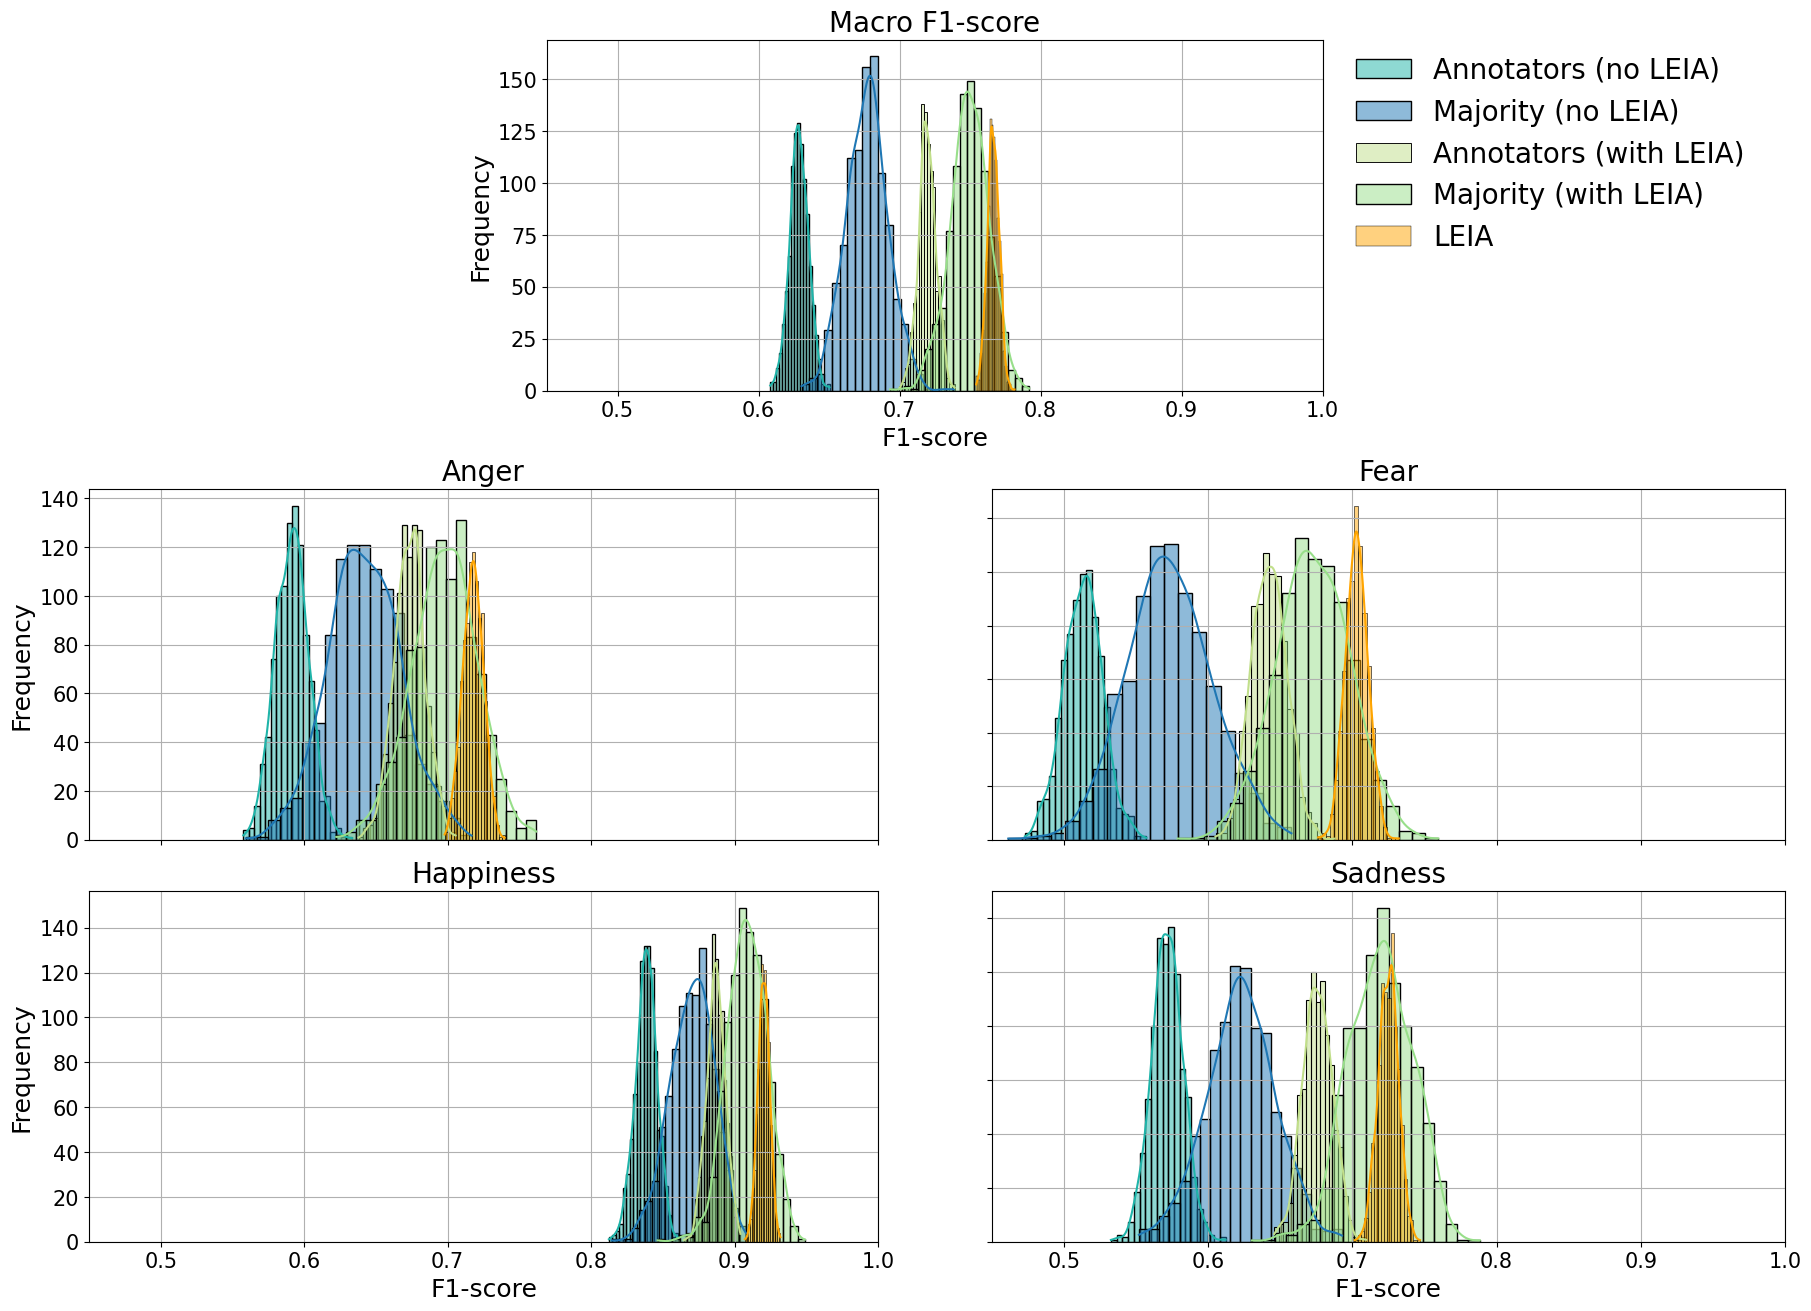

In [78]:
macro_f1_dist_all_models(data_dict, model_colors, fontsize=20)


In [79]:
records = []

for source, emo_dict in per_emotion_boot_distributions.items():
    for emotion, f1_list in emo_dict.items():
        for score in f1_list:
            records.append({
                "Source": source,
                "Emotion": emotion,
                "F1-score": score
            })

for source, macro_list in macro_boot_distributions.items():
    for score in macro_list:
        records.append({
            "Source": source,
            "Emotion": "Macro",
            "F1-score": score
        })

# Create DataFrame
per_emotion_f1_df = pd.DataFrame(records)


In [80]:
model_colors = {}

for group, readable_names in group_order.items():
    base_color = group_base_colors[group]
    n = len(readable_names)
    similar_colors = generate_similar_colors(base_color, n)
    for name, color in zip(readable_names, similar_colors):
        model_colors[name] = color


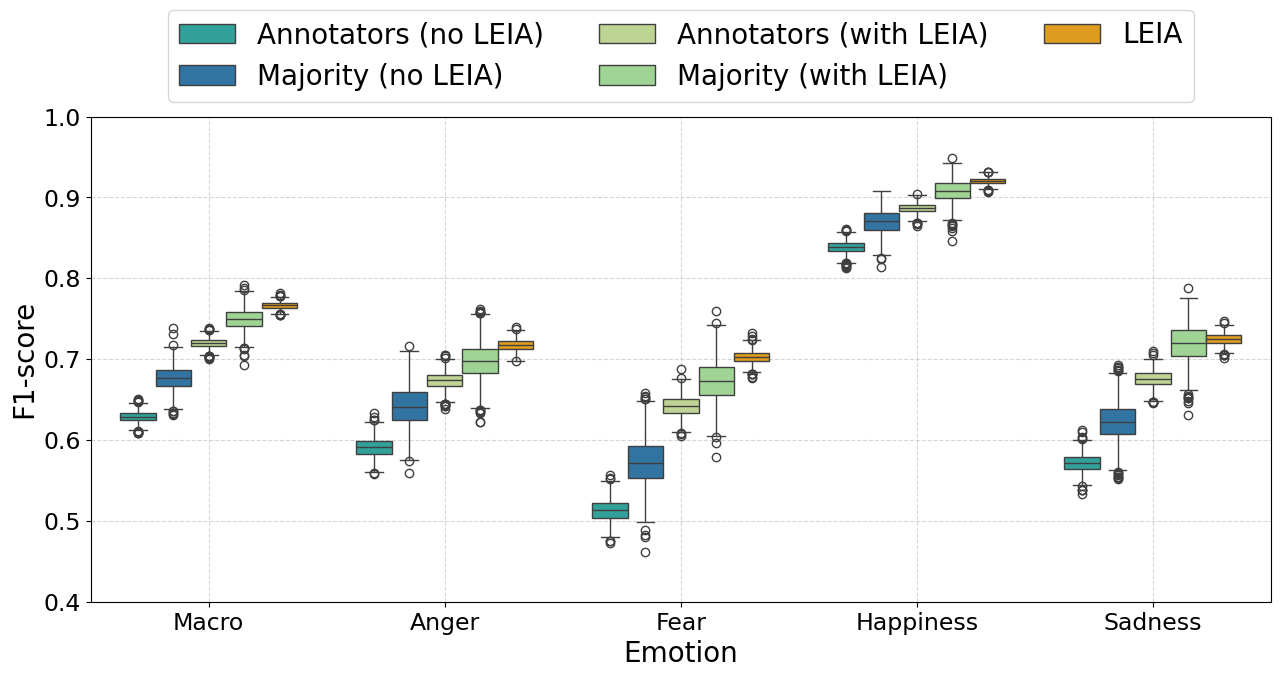

In [81]:

# Include Macro in emotion order
temp_emotions = ['Macro', 'Anger', 'Fear', 'Happiness', 'Sadness']


plt.figure(figsize=(13, 7))
sns.boxplot(
    x='Emotion',
    y='F1-score',
    data=per_emotion_f1_df,
    hue='Source',
    order=temp_emotions,
    palette=model_colors,
    width=0.75
)

plt.xlabel("Emotion", fontsize=20)
plt.ylabel("F1-score", fontsize=20)
plt.ylim(0.4, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(labelsize=17)


plt.legend(
    title='',
    bbox_to_anchor=(0.5, 1.22),
    loc='upper center',
    borderaxespad=0,
    ncol=3,
    fontsize=20
)
plt.tight_layout()

plt.savefig(f"../images/exp2-boxplots-bootstrapped.pdf", bbox_inches="tight")
plt.show()


### 2.2 McNemar's test

In [ ]:


def normalize_text(text):

    """Normalize text columns. Remove any additions made for the layout in potato. 

    Returns:
        string: normalized text
    """
    text = unicodedata.normalize('NFKD', text)

    # Remove Leia label
    text = re.sub(r"<hr.*?>\s*LEIA classified this text as:.*?</strong>", "", text, flags=re.IGNORECASE | re.DOTALL)

    text = re.sub(r"<[^>]+>", " ", text)

    text = re.sub(r'[^\w\s.,!?\'\"-]', '', text)

    text = text.replace('\u00A0', ' ')
    text = re.sub(r'\s+', ' ', text)

    text = text.lower().strip().strip('"').strip("'").strip()

    return text



annotator_df_no_leia['norm_text'] = annotator_df_no_leia['text'].apply(normalize_text)
annotator_df_leia['norm_text'] = annotator_df_leia['text'].apply(normalize_text)



In [83]:

no_leia = (
    annotator_df_no_leia[["norm_text", "label", "true_label"]]
    .rename(columns={"label": "label"})
    .assign(repetition=lambda d: d.groupby("norm_text").cumcount())
)

with_leia = (
    annotator_df_leia[["norm_text", "label", "true_label"]]
    .rename(columns={"label": "label_with_leia"})
    .assign(repetition=lambda d: d.groupby("norm_text").cumcount())
)


paired = no_leia.merge(with_leia,
                    on=["norm_text", "true_label", "repetition"],
                    how="inner")





In [ ]:

anno_maj_aggr_emot_no_leia['norm_text'] = anno_maj_aggr_emot_no_leia['text'].apply(normalize_text)
anno_maj_aggr_emot_leia['norm_text'] = anno_maj_aggr_emot_leia['text'].apply(normalize_text)



anno_maj_no_leia = anno_maj_aggr_emot_no_leia[["norm_text", "annotator_majority", "true_label"]].rename(columns={"annotator_majority": "annotator_majority"})




anno_maj_with_leia = anno_maj_aggr_emot_leia[["norm_text", "annotator_majority", "true_label"]].rename(columns={"annotator_majority": "annotator_majority_with_leia"})



anno_maj_paired = anno_maj_no_leia.merge(anno_maj_with_leia,
                    on=["norm_text", "true_label"],
                    how="inner")


In [85]:

def mcnemar_all_users_vs_leia(df, individual = True, humans_vs_humans = False):

    """Calculating McNemar's test statistic for all humans (individual or majority) against LEIA

    Args: 
        df: dataframe used individual or majority
        individual (boolean): parameter to get correct column
        humans_vs_humans (boolean): if we compare against LEIA or humans within conditions

    Returns:
        p_value: one-sided p-value of McNemar's test
        annotator_df: dataframe containing values of human or LEIA correct
        contingency_table: contigency table used to calculate McNemar's test
        mc_stat: Chi-squared and p_value
    """


    df = df.copy()


    if individual:
        df["model1_correct"] = (df["label"] == df["true_label"]).astype(int)
        if humans_vs_humans:
            df["model2_correct"] = (df["label_with_leia"] == df["true_label"]).astype(int)
        else:
            df["model2_correct"] = (df["Leia_Label"] == df["true_label"]).astype(int)
    else:
        df["model1_correct"] = (df["annotator_majority"] == df["true_label"]).astype(int)
        if humans_vs_humans:
            df["model2_correct"] = (df["annotator_majority_with_leia"] == df["true_label"]).astype(int)
        else:
            df["model2_correct"] = (df["Leia_Label"] == df["true_label"]).astype(int)


    
    contingency_table = np.zeros((2, 2))
    contingency_table[0, 0] = ((df["model1_correct"] == 1) & (df["model2_correct"] == 1)).sum()  # Both correct
    contingency_table[0, 1] = ((df["model1_correct"] == 0) & (df["model2_correct"] == 1)).sum()  # Model correct, human wrong (c)
    contingency_table[1, 0] = ((df["model1_correct"] == 1) & (df["model2_correct"] == 0)).sum()  # Human correct, model wrong (b)
    contingency_table[1, 1] = ((df["model1_correct"] == 0) & (df["model2_correct"] == 0)).sum()  # Both wrong

    b = contingency_table[1, 0]
    c = contingency_table[0, 1]
    if b + c > 0:
        if b + c > 25:
            result = mcnemar(contingency_table, exact=False)
        else:
            result = mcnemar(contingency_table, exact=True, correction=False)

        # One-tailed p-value (is Leia better?)
        if c > b:
            one_tailed_p = result.pvalue / 2
        else:
            one_tailed_p = 1.0

        return one_tailed_p, df, contingency_table, result
    else:
        return "No disagreements between humans and Leia, McNemar's test not applicable."

    

p_val, annotator_df, contingency_table, mc_stat = mcnemar_all_users_vs_leia(annotator_df)

p_val

5.662895928278084e-106

In [86]:


p_val_hum_v_hum, annotator_df_hum_v_hum, contingency_table_hum_v_hum, mc_stat_hum_v_hum = mcnemar_all_users_vs_leia(paired, True, humans_vs_humans=True)
p_val_hum_v_hum

print(mc_stat_hum_v_hum)

contingency_table_hum_v_hum

pvalue      4.737054950569485e-37
statistic   161.73076923076923


array([[2800.,  803.],
       [ 367., 1030.]])

In [87]:
p_val_hum_v_hum_majority, annotator_df_hum_v_hum_majority, contingency_table_hum_v_hum_majority, mc_stat_hum_v_hum_majority = mcnemar_all_users_vs_leia(anno_maj_paired, False, humans_vs_humans=True)
p_val_hum_v_hum_majority

print(mc_stat_hum_v_hum_majority)

contingency_table_hum_v_hum_majority

pvalue      8.534911389345975e-08
statistic   28.680722891566266


array([[633., 118.],
       [ 48., 201.]])

In [88]:
p_val_no_leia, annotator_df_no_leia, contingency_table_no_leia, mc_stat_no_leia = mcnemar_all_users_vs_leia(annotator_df_no_leia)
p_val_no_leia

print(mc_stat_no_leia)

contingency_table_no_leia

pvalue      4.8336352887974606e-80
statistic   358.92219492219493


array([[2888.,  942.],
       [ 279.,  891.]])

In [89]:
p_val_leia, annotator_df_leia, contingency_table_leia, mc_stat_leia = mcnemar_all_users_vs_leia(annotator_df_leia)
print(mc_stat_leia)

contingency_table_leia

pvalue      3.0516985369850335e-27
statistic   116.8787185354691


array([[3498.,  332.],
       [ 105., 1065.]])

In [90]:
round(p_val_leia, 4)

0.0

In [91]:
print(mc_stat_leia)

print(mc_stat_no_leia)

pvalue      3.0516985369850335e-27
statistic   116.8787185354691
pvalue      4.8336352887974606e-80
statistic   358.92219492219493


In [92]:

anno_maj_p_val,anno_maj_aggr_emot, anno_maj_contingency_table, testing_result  = mcnemar_all_users_vs_leia(anno_maj_aggr_emot, False)
anno_maj_p_val


1.521809209647493e-11

In [93]:
anno_maj_p_val_no_leia, anno_maj_aggr_emot_no_leia, anno_maj_contingency_table_no_leia, testing_result_no_leia = mcnemar_all_users_vs_leia(anno_maj_aggr_emot_no_leia, False)

print(testing_result_no_leia)


pvalue      6.582809997112641e-10
statistic   38.14054054054054


In [94]:
anno_maj_contingency_table_no_leia

array([[631., 135.],
       [ 50., 184.]])

In [95]:
anno_maj_p_val_leia, anno_maj_aggr_emot_leia, anno_maj_contingency_table_leia, testing_result_leia = mcnemar_all_users_vs_leia(anno_maj_aggr_emot_leia, False)
print(testing_result_leia)
anno_maj_contingency_table_leia

pvalue      0.021358540433834634
statistic   5.297297297297297


array([[740.,  26.],
       [ 11., 223.]])

In [96]:
746+20+13+221

1000

In [97]:
anno_maj_contingency_table_leia

array([[740.,  26.],
       [ 11., 223.]])

In [98]:
print(testing_result_leia)

pvalue      0.021358540433834634
statistic   5.297297297297297


In [99]:
print(testing_result_no_leia)

pvalue      6.582809997112641e-10
statistic   38.14054054054054


In [100]:
print(testing_result)

pvalue      3.043618419294986e-11
statistic   44.148648648648646


In [ ]:
def mcnem_per_participant(annotators, restructured_results):
    """McNemar's test per participant on respective sample

    Returns:
        dataframe: dataframe with McNemar's results per participants
        dictionary: contigency tables per participant
    """

    mcnemar_results = {}
    user_cont_tables = {}

    for user in annotators:
        user_df = restructured_results[restructured_results["user_id"] == user]

        contingency_table = np.zeros((2, 2))
        contingency_table[0, 0] = ((user_df["model1_correct"] == 1) & (user_df["model2_correct"] == 1)).sum()  # Both correct
        contingency_table[0, 1] = ((user_df["model1_correct"] == 0) & (user_df["model2_correct"] == 1)).sum()  # Model correct, human wrong (c)
        contingency_table[1, 0] = ((user_df["model1_correct"] == 1) & (user_df["model2_correct"] == 0)).sum()  # Human correct, model wrong (b)
        contingency_table[1, 1] = ((user_df["model1_correct"] == 0) & (user_df["model2_correct"] == 0)).sum()  # Both wrong

        result = mcnemar(contingency_table)#, exact=True, correction=True)
        
        # One-tailed p-value adjustment
        b, c = contingency_table[1, 0], contingency_table[0, 1]
        if c > b:
            one_tailed_p = result.pvalue / 2  # Model performs better
        else:
            one_tailed_p = 1  # Humans perform better, force non-significance
            

        mcnemar_results[user] = {
            "p-value": round(one_tailed_p, 5), 
            "statistic": result.statistic
        }
        user_cont_tables[user] = contingency_table

    mcnemar_df = pd.DataFrame.from_dict(mcnemar_results, orient="index")

    return mcnemar_df, user_cont_tables

mcnemar_by_participant, participant_contingency_tables = mcnem_per_participant(annotators, annotator_df)

mcnemar_by_participant


In [102]:
significance_level = 0.05

significant_leia_wins = mcnemar_by_participant[
    (mcnemar_by_participant["p-value"] < significance_level) &
    (mcnemar_by_participant.index.map(lambda user: participant_contingency_tables[user][0, 1] > participant_contingency_tables[user][1, 0]))  # LEIA better
]

num_leia_wins = len(significant_leia_wins)
total_participants = len(mcnemar_by_participant)
percentage_leia_wins = (num_leia_wins / total_participants) * 100

print(f"LEIA performs significantly better than the human annotators in {num_leia_wins} out of {total_participants} cases.")
print(f"That's about {percentage_leia_wins:.2f}% of the participants.")


LEIA performs significantly better than the human annotators in 53 out of 255 cases.
That's about 20.78% of the participants.


In [104]:
def mcnemar_per_emot(emotions, restructured_results, model1_correct = 'model1_correct', model2_correct = 'model2_correct'):
    """Calculating McNemar's test statistic for all humans against LEIA per emotion

    Args: 
        annotator: list of annotators
        restructured_results (dataframe): dataframe with annotator as rows

    Returns:
        dataframe of McNemar's test results per emotion
        contingency tables(dictionary): per emotion
    """
    
    mcnemar_results = {}
    contingency_tables = {}

    for emotion in emotions:
        df_emotion = restructured_results[restructured_results["true_label"] == emotion]
        
        contingency_table = np.zeros((2, 2))
        contingency_table[0, 0] = ((df_emotion[model1_correct] == 1) & (df_emotion[model2_correct] == 1)).sum()  # Both correct
        contingency_table[0, 1] = ((df_emotion[model1_correct] == 0) & (df_emotion[model2_correct] == 1)).sum()  # Model correct, human wrong (c)
        contingency_table[1, 0] = ((df_emotion[model1_correct] == 1) & (df_emotion[model2_correct] == 0)).sum()  # Human correct, model wrong (b)
        contingency_table[1, 1] = ((df_emotion[model1_correct] == 0) & (df_emotion[model2_correct] == 0)).sum()  # Both wrong
        #contingency_tables[emotion] = np.array(contingency_table)
        if contingency_table[0, 1] + contingency_table[1, 0] > 0:

                b, c = contingency_table[1, 0], contingency_table[0, 1]

                if b + c > 25:
                    result = mcnemar(contingency_table, exact=False)
                else:
                    result = mcnemar(contingency_table, exact=True, correction=False)
        contingency_tables[emotion] = np.array(contingency_table)

        b, c = contingency_table[1, 0], contingency_table[0, 1]
        # One-tailed p-value adjustment
        if c > b:
            one_tailed_p = result.pvalue / 2  # Model performs better
        else:
            one_tailed_p = 1  # Humans perform better, force non-significance

        mcnemar_results[emotion] = {
            "p-value": round(one_tailed_p, 5), 
            "statistic": result.statistic
        }

    mcnemar_df = pd.DataFrame.from_dict(mcnemar_results, orient="index")

    return mcnemar_df, contingency_tables

mcnemar_per_emotion, emot_contingency_tables = mcnemar_per_emot(emotions, annotator_df)
emot_contingency_tables



{'Anger': array([[1499.,  371.],
        [ 100.,  530.]]),
 'Fear': array([[1134.,  466.],
        [  94.,  806.]]),
 'Happiness': array([[2142.,  108.],
        [  42.,  208.]]),
 'Sadness': array([[1611.,  329.],
        [ 148.,  412.]])}

In [105]:
mcnemar_per_emotion_no_leia, emot_contingency_tables_no_leia = mcnemar_per_emot(emotions, annotator_df_no_leia)
emot_contingency_tables_no_leia


{'Anger': array([[664., 271.],
        [ 70., 245.]]),
 'Fear': array([[456., 344.],
        [ 73., 377.]]),
 'Happiness': array([[1048.,   77.],
        [  33.,   92.]]),
 'Sadness': array([[720., 250.],
        [103., 177.]])}

In [106]:
mcnemar_per_emotion_leia, emot_contingency_tables_leia = mcnemar_per_emot(emotions, annotator_df_leia)
emot_contingency_tables_leia


{'Anger': array([[835., 100.],
        [ 30., 285.]]),
 'Fear': array([[678., 122.],
        [ 21., 429.]]),
 'Happiness': array([[1094.,   31.],
        [   9.,  116.]]),
 'Sadness': array([[891.,  79.],
        [ 45., 235.]])}

In [107]:
mcnemar_per_emotion_no_leia

,p-value,statistic
Anger,0.00000,117.302053
Fear,0.00000,174.820144
Happiness,0.00002,16.809091
Sadness,0.00000,60.385269


In [108]:
mcnemar_per_emotion_leia

,p-value,statistic
Anger,0.00000,36.623077
Fear,0.00000,69.930070
Happiness,0.00045,11.025000
Sadness,0.00152,8.782258


In [109]:
mcnemar_per_emotion, emot_contingency_tables = mcnemar_per_emot(emotions, anno_maj_aggr_emot)
emot_contingency_tables


{'Anger': array([[326.,  48.],
        [ 15., 111.]]),
 'Fear': array([[251.,  69.],
        [ 13., 167.]]),
 'Happiness': array([[439.,  11.],
        [  7.,  43.]]),
 'Sadness': array([[355.,  33.],
        [ 26.,  86.]])}

In [110]:
mcnemar_per_emotion, emot_contingency_tables = mcnemar_per_emot(emotions, anno_maj_aggr_emot_leia)
emot_contingency_tables


{'Anger': array([[177.,  10.],
        [  5.,  58.]]),
 'Fear': array([[147.,  13.],
        [  1.,  89.]]),
 'Happiness': array([[223.,   2.],
        [  1.,  24.]]),
 'Sadness': array([[193.,   1.],
        [  4.,  52.]])}

In [111]:
mcnemar_per_emotion

,p-value,statistic
Anger,0.15088,5.0
Fear,0.00092,1.0
Happiness,0.50000,1.0
Sadness,1.00000,1.0


In [112]:
anno_maj_per_emot

,precision,recall,f1_score
Macro Average,0.72875,0.716,0.714
Sadness,0.59800,0.762,0.670
Anger,0.66000,0.682,0.671
Fear,0.77000,0.528,0.626
Happiness,0.88700,0.892,0.889


In [113]:
mcnemar_per_emotion, emot_contingency_tables = mcnemar_per_emot(emotions, anno_maj_aggr_emot_no_leia)
emot_contingency_tables


{'Anger': array([[149.,  38.],
        [ 10.,  53.]]),
 'Fear': array([[104.,  56.],
        [ 12.,  78.]]),
 'Happiness': array([[216.,   9.],
        [  6.,  19.]]),
 'Sadness': array([[162.,  32.],
        [ 22.,  34.]])}

In [123]:
mcnemar_per_emot(emotions, annotator_df_hum_v_hum_majority)

(           p-value  statistic
 Anger      0.00030  11.804878
 Fear       0.00002  16.568966
 Happiness  0.39526   6.000000
 Sadness    0.04964   2.716981,
 {'Anger': array([[150.,  32.],
         [  9.,  59.]]),
  'Fear': array([[103.,  45.],
         [ 13.,  89.]]),
  'Happiness': array([[216.,   8.],
         [  6.,  20.]]),
  'Sadness': array([[164.,  33.],
         [ 20.,  33.]])})

In [124]:
mcnemar_per_emot(emotions, annotator_df_hum_v_hum)

(           p-value  statistic
 Anger      0.00000  54.692557
 Fear       0.00000  75.160526
 Happiness  0.02762   3.675000
 Sadness    0.00000  34.747922,
 {'Anger': array([[645., 220.],
         [ 89., 296.]]),
  'Fear': array([[424., 275.],
         [105., 446.]]),
  'Happiness': array([[1032.,   71.],
         [  49.,   98.]]),
  'Sadness': array([[699., 237.],
         [124., 190.]])})

### 2.3 Additional

#### 2.3.1 Confusion Matrix

In [223]:


def plot_confusion_matrix_comparison_grid(df_list, col_list, title_list, true_col='true_label',
                                          leia_col='Leia_Label', emotions=None,
                                          base_fs=20, tick_fs=18, cell_fs=18, save_name=''):
    """
    Plots 3 confusion matrices: 2 on top row, 1 centered on bottom row.

    Parameters:
    - df_list: list of 3 dataframes
    - col_list: list of 3 column names (predictions to compare against true)
    - title_list: list of 3 subplot titles
    - emotions: list of emotion labels for ordering
    - save_name: filename suffix for saving (without extension)
    """

    assert len(df_list) == len(col_list) == len(title_list) == 3, "Must provide 3 elements for each input."

    fig = plt.figure(figsize=(14, 14))
    gs = fig.add_gridspec(2, 4)

    axes = [
        fig.add_subplot(gs[0, 0:2]),  
        fig.add_subplot(gs[0, 2:4]), 
        fig.add_subplot(gs[1, 1:3])   
    ]

    for i, (df, pred_col, title, ax) in enumerate(zip(df_list, col_list, title_list, axes)):
        cm = confusion_matrix(df[true_col], df[pred_col], normalize='true', labels=emotions)
        disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
        disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format=".2f")
        disp.im_.set_clim(0, 1)

        ax.set_title(title, y=1.05, fontsize=base_fs + 6, weight="bold")
        ax.set_xlabel("Predicted label", fontsize=base_fs, labelpad=15)
        ax.set_ylabel("True label", fontsize=base_fs, labelpad=15)
        ax.tick_params(axis="both", labelsize=tick_fs)

        if i != 0:
            ax.get_yaxis().set_visible(False)

        for txt in disp.text_.ravel():
            txt.set_fontsize(cell_fs)

    fig.tight_layout()

    fig.savefig(f"../images/exp2-confusion_grid_{save_name}.pdf",
            bbox_inches='tight', dpi=300, pad_inches=0.3)

    plt.show()


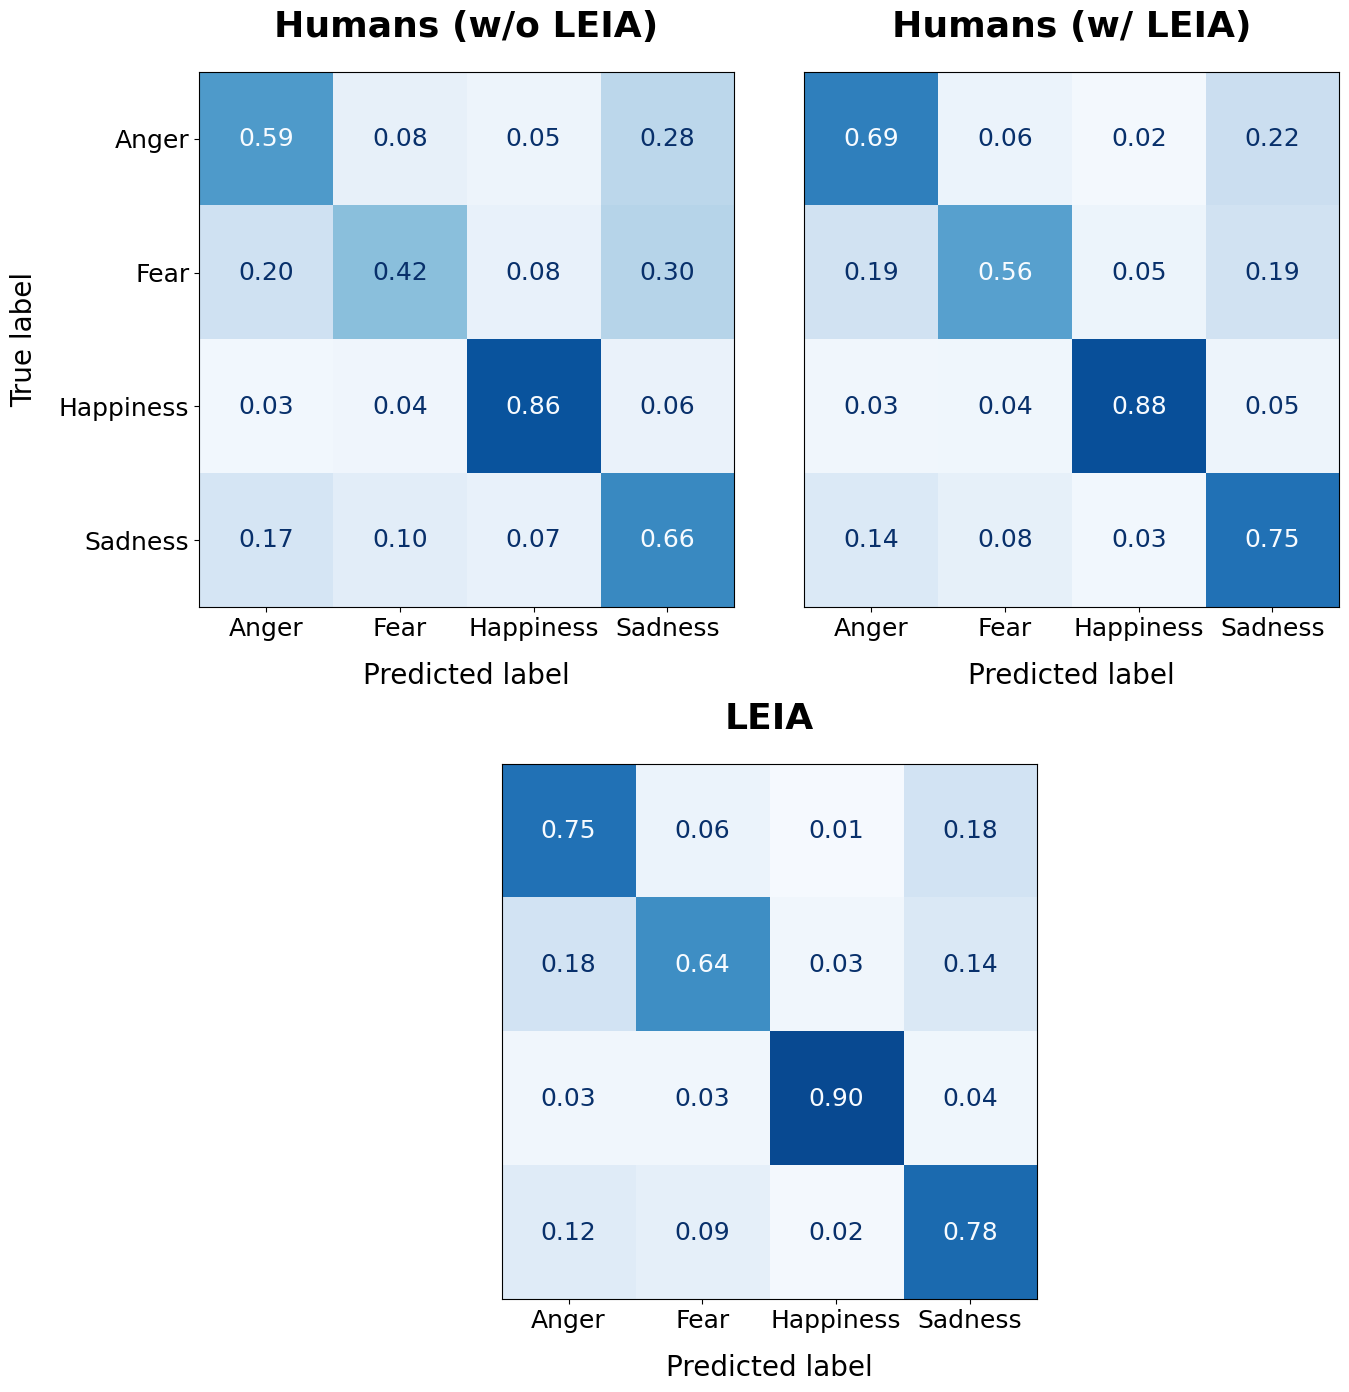

In [224]:
plot_confusion_matrix_comparison_grid(
    df_list=[annotator_df_no_leia, annotator_df_leia, annotator_df],
    col_list=['label', 'label', 'Leia_Label'],
    title_list=['Humans (w/o LEIA)', 'Humans (w/ LEIA)', 'LEIA'],
    emotions=emotions,
    save_name='individual'
)


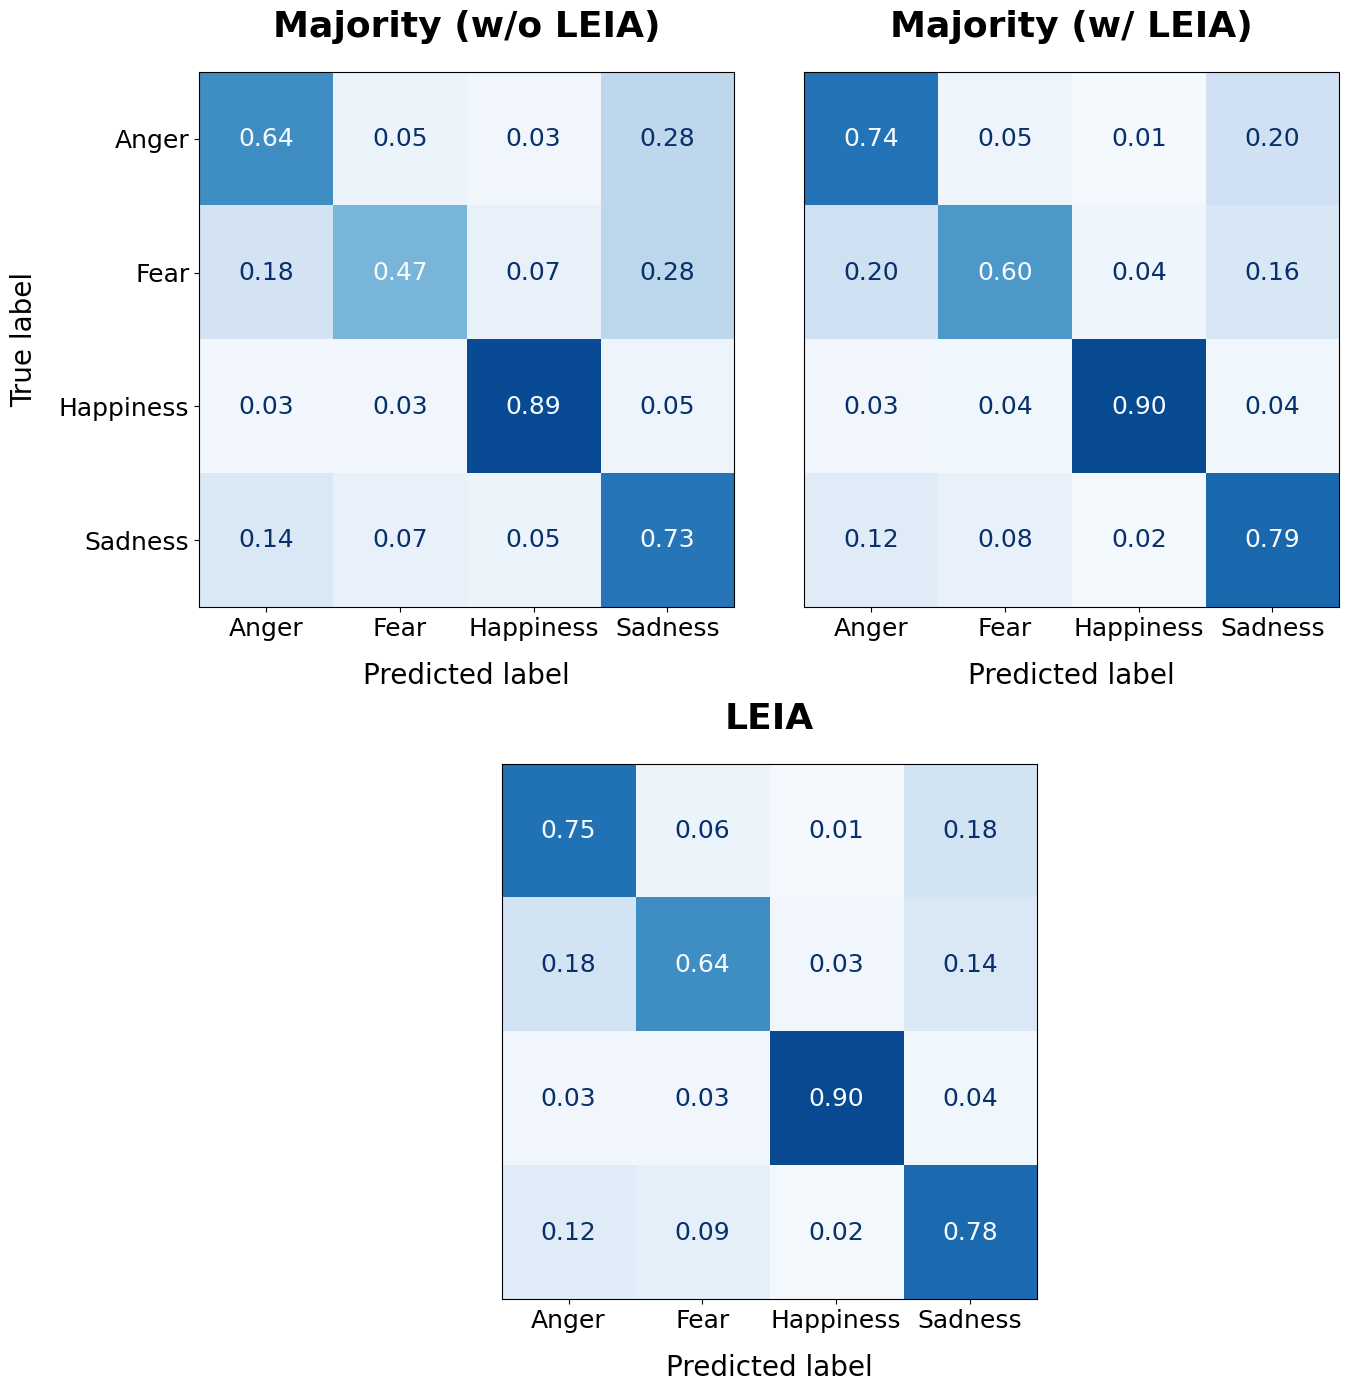

In [225]:
plot_confusion_matrix_comparison_grid(
    df_list=[anno_maj_aggr_emot_no_leia, anno_maj_aggr_emot_leia, anno_maj_aggr_emot],
    col_list=['annotator_majority', 'annotator_majority', 'Leia_Label'],
    title_list=['Majority (w/o LEIA)', 'Majority (w/ LEIA)', 'LEIA'],
    emotions=emotions,
    save_name='majority'
)


## Additional Analysis, factor of adding LEIA


In [229]:


annotator_df_no_leia.rename(columns={'label': 'human_label'}, inplace=True)
annotator_df_leia.rename(columns={'label': 'human_label'}, inplace=True)


annotator_df_leia['conformity'] = annotator_df_leia['human_label'] == annotator_df_leia['Leia_Label']
conformity_rate = annotator_df_leia['conformity'].mean()
print(f"🧠 Human Conformity Rate with LEIA (Exp2): {conformity_rate:.2%}")

def influence_case(row):
    leia_correct = row['Leia_Correct']
    human_correct = row['Human_Correct']
    conforms = row['human_label'] == row['Leia_Label']

    if leia_correct and conforms:
        return 'LEIA Correct + Conform'
    elif not leia_correct and conforms:
        return 'LEIA Wrong + Conform'
    elif not leia_correct and not conforms:
        return 'LEIA Wrong + Resist'
    elif leia_correct and not conforms:
        return 'LEIA Correct + Resist'
    else:
        return 'Other'

annotator_df_leia['influence_case'] = annotator_df_leia.apply(influence_case, axis=1)


influence_summary = annotator_df_leia['influence_case'].value_counts()
print("\n📊 Influence Case Breakdown (Exp2):")
print(influence_summary)






🧠 Human Conformity Rate with LEIA (Exp2): 89.26%

📊 Influence Case Breakdown (Exp2):
influence_case
LEIA Correct + Conform    3498
LEIA Wrong + Conform       965
LEIA Correct + Resist      332
LEIA Wrong + Resist        205
Name: count, dtype: int64


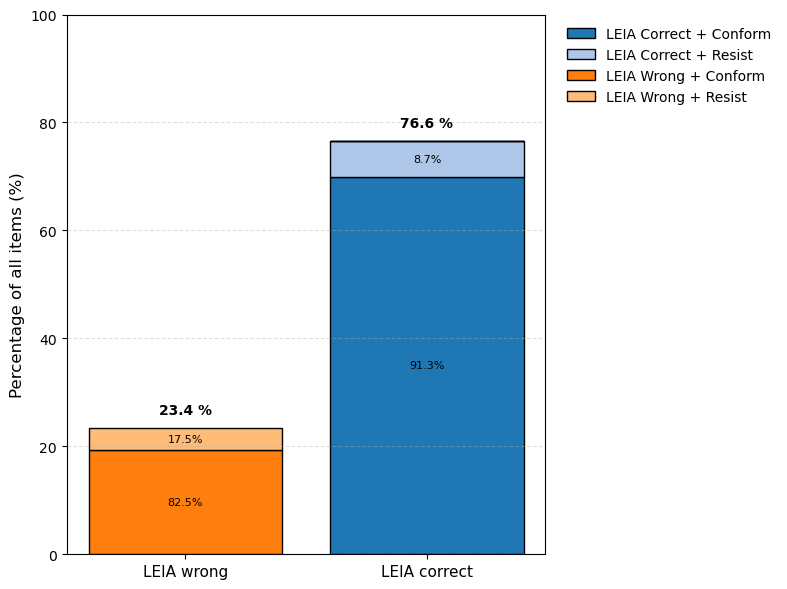

In [231]:

counts = (
    annotator_df_leia
      .groupby("Leia_Correct")["influence_case"]
      .value_counts()
      .unstack(fill_value=0)
)

row_tot   = counts.sum(axis=1)
grand_tot = row_tot.sum()
row_prop  = row_tot / grand_tot * 100          # [wrong %, correct %]

row_share = counts.div(row_tot, axis=0)        # rows sum to 1


fig, ax = plt.subplots(figsize=(8, 6))

x_pos      = [0, 1]                            # 0 = wrong, 1 = correct
bar_labels = ["LEIA wrong", "LEIA correct"]
case_order = row_share.columns.tolist()
colors     = plt.get_cmap("tab20").colors[:len(case_order)]
pct_thr    = 5.0                               # threshold for stacked bar being too small

bottom = [0, 0]

for case, color in zip(case_order, colors):

    heights = row_prop.values * row_share[case].values   # global % for slice
    bars    = ax.bar(x_pos, heights, bottom=bottom,
                     color=color, edgecolor='black', label=case)

    # annotate slice
    for idx, bar in enumerate(bars):
        pct_in_bar = row_share.iloc[idx][case] * 100     # 0–100 inside bar
        y0, h = bar.get_y(), bar.get_height()
        if pct_in_bar >= pct_thr:
            ax.text(bar.get_x()+bar.get_width()/2,
                    y0 + h/2,
                    f"{pct_in_bar:.1f}%",
                    ha='center', va='center', fontsize=8, color='black')
        elif pct_in_bar > 0:
            # thin coloured line
            ax.hlines(y0+h, bar.get_x(), bar.get_x()+bar.get_width(),
                      colors=color, linewidth=1.2)
            ax.text(bar.get_x()+bar.get_width()/2,
                    y0 + h + 1,               # 1 % above bar
                    f"{pct_in_bar:.1f}%",
                    ha='center', va='bottom', fontsize=8)
    bottom = [b + h for b, h in zip(bottom, heights)]

for x, pct in zip(x_pos, row_prop):
    ax.text(x, pct + 2, f"{pct:.1f} %", ha='center', va='bottom',
            fontsize=10, weight='bold', color='black')



ax.set_xticks(x_pos)
ax.set_xticklabels(bar_labels, fontsize=11)
ax.set_ylabel("Percentage of all items (%)", fontsize=12)
ax.set_ylim(0, 100)

ax.grid(axis='y', linestyle='--', alpha=.4)

handles = [Patch(facecolor=c, edgecolor='black', label=case)
           for case, c in zip(case_order, colors)]
ax.legend(handles=handles, frameon=False,
          bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [232]:

class HandlerCircle(HandlerPatch):

    """Helper Function to generate a circle in the legend and not a square
    """
    def __init__(self, size=1.0, **kwargs):
        self.size = size  
        super().__init__(**kwargs)

    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        size = self.size
        center = (xdescent + width / 2, ydescent + height / 2)
        radius = size * min(width, height) / 2

        def get_rgba(color):
            return color if isinstance(color[0], (float, int)) else tuple(color[0])

        fc = get_rgba(orig_handle.get_facecolor())
        ec = get_rgba(orig_handle.get_edgecolor())

        circle = mpatches.Circle(center, radius,
                                 facecolor=fc,
                                 edgecolor=ec,
                                 lw=orig_handle.get_linewidth())
        circle.set_transform(trans)
        return [circle]



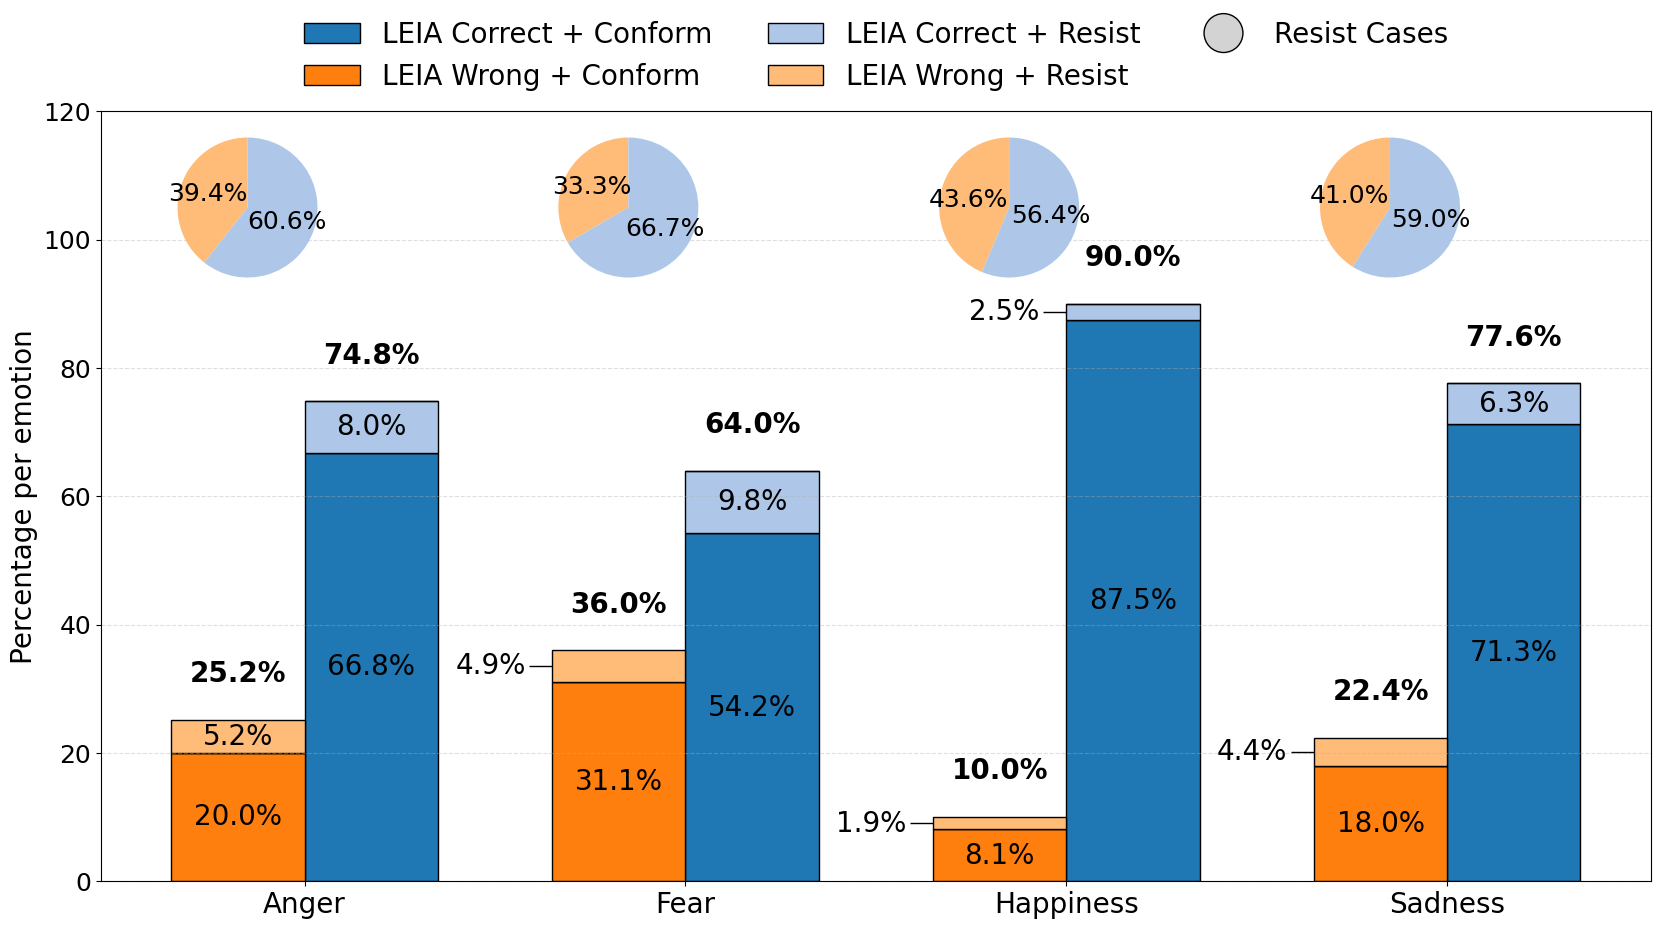

In [ ]:
emotions = ['Anger', 'Fear', 'Happiness', 'Sadness']
custom_colors = {
    "LEIA Correct + Conform": "#1f77b4",  # blue
    "LEIA Correct + Resist":  "#aec7e8",  # orange
    "LEIA Wrong + Conform":   "#ff7f0e",  # green
    "LEIA Wrong + Resist":    "#ffbb78",  # red
}

FONTSIZE = 20

influence_cases = annotator_df_leia["influence_case"].unique().tolist()

influence_cases = sorted(influence_cases, key=lambda x: ('Resist' in x, x))

colors = [custom_colors[case] for case in influence_cases]

bar_width = 0.35
spacing = 1.0
x_pos = [i * spacing for i in range(len(emotions))]

fig, ax = plt.subplots(figsize=(20, 10))

xtick_positions = []
xtick_labels = []

for i, emo in enumerate(emotions):
    subset = annotator_df_leia[annotator_df_leia["true_label"] == emo]

    counts = (
        subset.groupby("Leia_Correct")["influence_case"]
              .value_counts()
              .unstack(fill_value=0)
              .reindex([False, True])
    )

    row_totals = counts.sum(axis=1)
    emo_total = row_totals.sum()

    if emo_total == 0:
        continue

    bar_height = row_totals / emo_total * 100
    row_share = counts.div(row_totals, axis=0).fillna(0)

    bar_wrong_x = x_pos[i] - bar_width / 2
    bar_correct_x = x_pos[i] + bar_width / 2

    bottoms = [0, 0]

    for j, case in enumerate(influence_cases):
        h_wrong = bar_height.iloc[0] * row_share.loc[False, case]
        h_correct = bar_height.iloc[1] * row_share.loc[True, case]

        bar1 = ax.bar(bar_wrong_x, h_wrong, bottom=bottoms[0],
                      width=bar_width, color=colors[j], edgecolor="black")
        bar2 = ax.bar(bar_correct_x, h_correct, bottom=bottoms[1],
                      width=bar_width, color=colors[j], edgecolor="black")

        for bar, h, base in zip([bar1[0], bar2[0]], [h_wrong, h_correct], bottoms):
            if h == 0:
                continue

            label = f"{h:.1f}%" if h >= 0.1 else "<0.1%"
            x_center = bar.get_x() + bar.get_width() / 2
            y_center = base + h / 2

            if h >= 5:
                ax.text(x_center, y_center,
                        label, ha='center', va='center',
                        fontsize=FONTSIZE, color='black')
            else:
                x_text = bar.get_x() - 0.07  
                ax.text(x_text, y_center,
                        label, ha='right', va='center',
                        fontsize=FONTSIZE, color='black')

                ax.hlines(y=y_center, xmin=x_text + 0.01, xmax=bar.get_x(),
                        colors='black', linewidth=1)



        bottoms[0] += h_wrong
        bottoms[1] += h_correct

    ax.text(bar_wrong_x, bar_height.iloc[0] + 5, f"{bar_height.iloc[0]:.1f}%",
            ha='center', va='bottom', fontsize=FONTSIZE, weight='bold', color='black')
    ax.text(bar_correct_x, bar_height.iloc[1] + 5, f"{bar_height.iloc[1]:.1f}%",
            ha='center', va='bottom', fontsize=FONTSIZE, weight='bold', color='black')

    xtick_positions.append(x_pos[i])
    xtick_labels.append(emo)



    resist_subset = subset[subset["conformity"] == False]
    if not resist_subset.empty:
        pie_counts = resist_subset["Leia_Correct"].value_counts().reindex([0, 1], fill_value=0)

        pie_colors = ["#ffbb78", "#aec7e8"]  
        pie_labels = ["LEIA Wrong", "LEIA Correct"]
        x_mid = (bar_wrong_x + bar_correct_x) / 2
        y_top = max(bar_height) + 20  

        ax_pie = inset_axes(
            ax,
            width=1.75,                
            height=1.75,               
            loc='center',
            bbox_to_anchor=(x_mid-0.15, 105),
            bbox_transform=ax.transData,
            borderpad=3
        )
        ax_pie.pie(
            pie_counts,
            colors=pie_colors,
            startangle=90,

            labels=None, autopct="%1.1f%%",textprops={'fontsize': FONTSIZE-2}
        )
        ax_pie.set_aspect('equal')
        ax_pie.set_xticks([])
        ax_pie.set_yticks([])

        total_resist = pie_counts.sum()
        percentages = pie_counts / total_resist * 100
        labels = [f"{label}: {pct:.1f}%" for label, pct in zip(pie_labels, percentages)]


    

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, fontsize=FONTSIZE)


ax.set_ylabel("Percentage per emotion", fontsize=FONTSIZE)
ax.set_ylim(0, 120)  
ax.tick_params(axis='y', labelsize=FONTSIZE - 2)
ax.grid(axis="y", linestyle="--", alpha=0.4)


handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], ec='black') for i in range(len(influence_cases))]


pie_circle = mpatches.Circle((0, 0), radius=1, facecolor="lightgrey", edgecolor='black')
handles.append(pie_circle)
labels = influence_cases + ["Resist Cases"]

handler_map = {mpatches.Circle: HandlerCircle(size=2)}

ax.legend(handles, labels,
          handler_map=handler_map,
          loc='upper center',
          bbox_to_anchor=(0.5, 1.15),
          ncol=3,
          fontsize=FONTSIZE,
          frameon=False)




plt.savefig("../images/conformity_emotion.pdf",
                bbox_inches="tight", dpi=300)
plt.show()


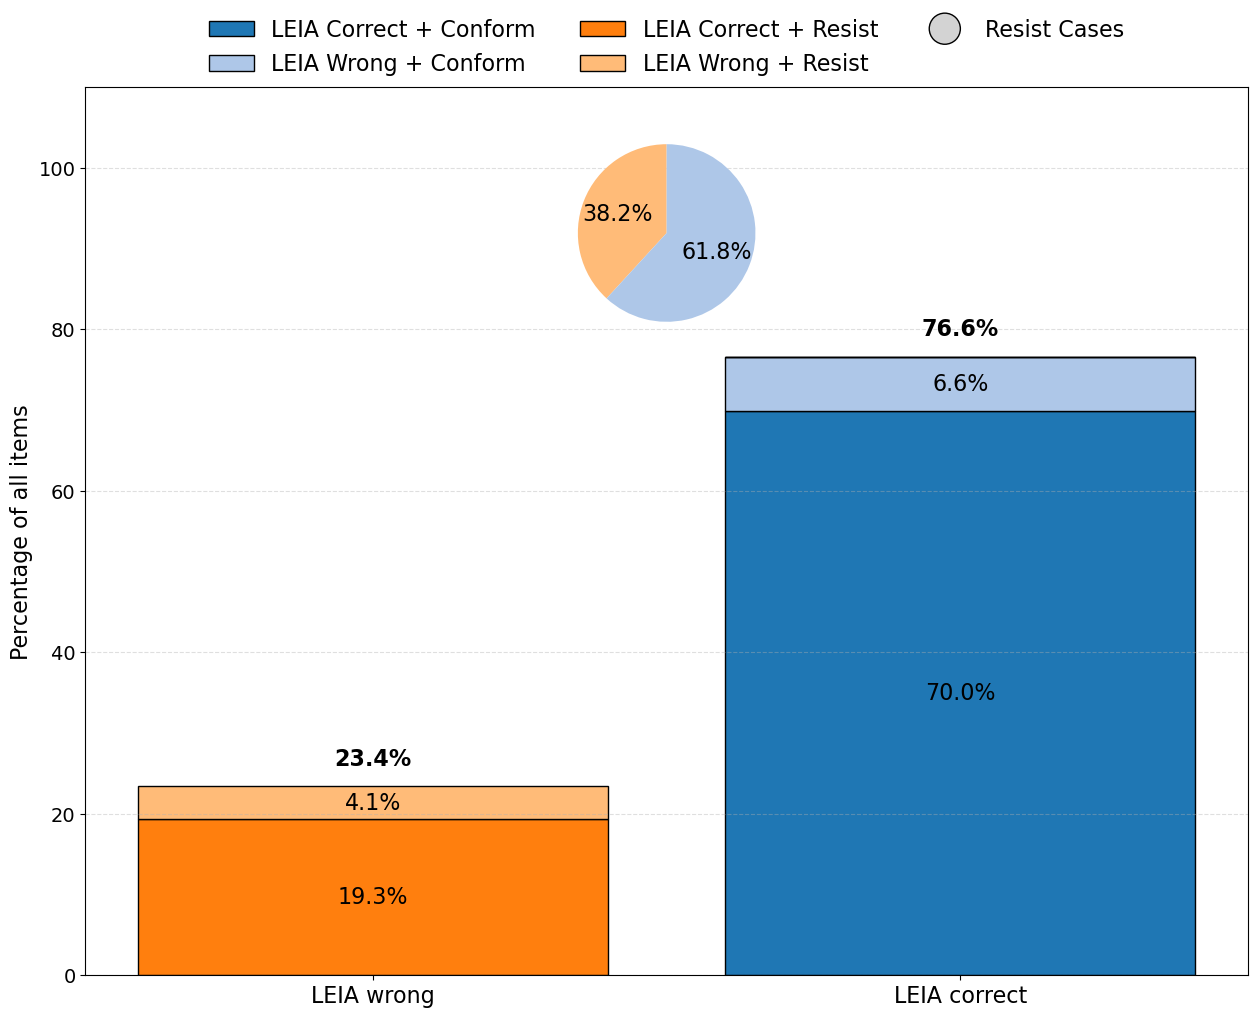

In [234]:
FONTSIZE = 16

# Prepare counts for LEIA correct/incorrect vs. influence cases
counts = (
    annotator_df_leia
      .groupby("Leia_Correct")["influence_case"]
      .value_counts()
      .unstack(fill_value=0)
      .reindex([False, True])  # Ensure rows in [LEIA wrong, LEIA correct] order
)

# Total percentage of items in each LEIA correctness category
row_tot   = counts.sum(axis=1)
grand_tot = row_tot.sum()
row_prop  = row_tot / grand_tot * 100

# Proportion of influence cases within each LEIA correctness group
row_share  = counts.div(row_tot, axis=0)
case_order = row_share.columns.tolist()
colors     = plt.get_cmap("tab20").colors[:len(case_order)]

# Main stacked bar plot
fig, ax  = plt.subplots(figsize=(15, 12))
x_pos    = [0, 1]
bar_lbls = ["LEIA wrong", "LEIA correct"]
bottom   = [0, 0]

for case, col in zip(case_order, colors):
    heights = row_prop.values * row_share[case].values
    bars    = ax.bar(x_pos, heights, bottom=bottom,
                     color=col, edgecolor='black', label=case)

    # Annotate each bar segment
    for h, y0, bar in zip(heights, bottom, bars):
        if h == 0:
            continue
        label = f"{h:.1f}%" if h >= 0.1 else "<0.1%"
        if h < 0.1:
            ax.hlines(y0 + h, bar.get_x(), bar.get_x() + bar.get_width(),
                      colors=col, linewidth=1)
            ax.text(bar.get_x() + bar.get_width() / 2, y0 + h + 0.5,
                    label, ha='center', va='bottom', fontsize=FONTSIZE)
        else:
            ax.text(bar.get_x() + bar.get_width() / 2, y0 + h / 2,
                    label, ha='center', va='center',
                    fontsize=FONTSIZE, color='black')
    bottom = [b + h for b, h in zip(bottom, heights)]

# Add total percentage label above each bar
for x, tot in zip(x_pos, row_prop):
    ax.text(x, tot + 2, f"{tot:.1f}%", ha='center',
            va='bottom', fontsize=FONTSIZE, weight='bold')

# Axis formatting
ax.set_xticks(x_pos)
ax.set_xticklabels(bar_lbls, fontsize=FONTSIZE)
ax.set_ylabel("Percentage of all items", fontsize=FONTSIZE)
ax.set_ylim(0, 110)
ax.grid(axis='y', linestyle='--', alpha=.4)
ax.tick_params(axis='y', labelsize=FONTSIZE - 2)

# Legend setup with extra pie chart symbol
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], ec='black') for i in range(len(influence_cases))]
pie_circle = mpatches.Circle((0, 0), radius=1, facecolor="lightgrey", edgecolor='black')
handles.append(pie_circle)
labels = influence_cases + ["Resist Cases"]
handler_map = {mpatches.Circle: HandlerCircle(size=2)}

ax.legend(handles, labels,
          handler_map=handler_map,
          loc='upper center',
          bbox_to_anchor=(0.5, 1.1),
          ncol=3,
          fontsize=FONTSIZE,
          frameon=False)

# Inset pie chart for breakdown of resistance cases by LEIA correctness
resist_df = annotator_df_leia[annotator_df_leia["conformity"] == 0]
resist_counts = resist_df["Leia_Correct"].value_counts().reindex([0, 1], fill_value=0)

if resist_counts.sum() > 0:
    pie_labels = ["LEIA wrong", "LEIA correct"]
    pie_colors = ["#ffbb78", "#aec7e8"]
    ax_pie = inset_axes(ax, width="25%", height="25%",
                        loc="upper center", borderpad=2.5)
    ax_pie.pie(resist_counts, labels=None, colors=pie_colors,
               autopct="%1.1f%%", startangle=90,
               textprops={'fontsize': FONTSIZE})

plt.subplots_adjust(top=0.85)
plt.savefig("../images/conformity_plot.pdf", bbox_inches="tight", dpi=300)
plt.show()


In [377]:


def aggregate_metrics(df):
    return df.groupby('Annotator').agg({
        'F1-score': 'mean',
        'Precision': 'mean',
        'Recall': 'mean',
        'Balanced-accuracy': 'mean'
    }).rename(columns=lambda x: x + '_mean')

metrics_agg_exp1 = aggregate_metrics(metrics_per_annotator_no_leia)
metrics_agg_exp2 = aggregate_metrics(metrics_per_annotator_leia)

metrics_compare = metrics_agg_exp1.merge(
    metrics_agg_exp2,
    left_index=True,
    right_index=True,
    suffixes=('_exp1', '_exp2')
)

for metric in ['F1-score', 'Precision', 'Recall', 'Balanced-accuracy']:
    col1 = f'{metric}_mean_exp1'
    col2 = f'{metric}_mean_exp2'
    diff_col = f'{metric}_diff'
    metrics_compare[diff_col] = metrics_compare[col2] - metrics_compare[col1]




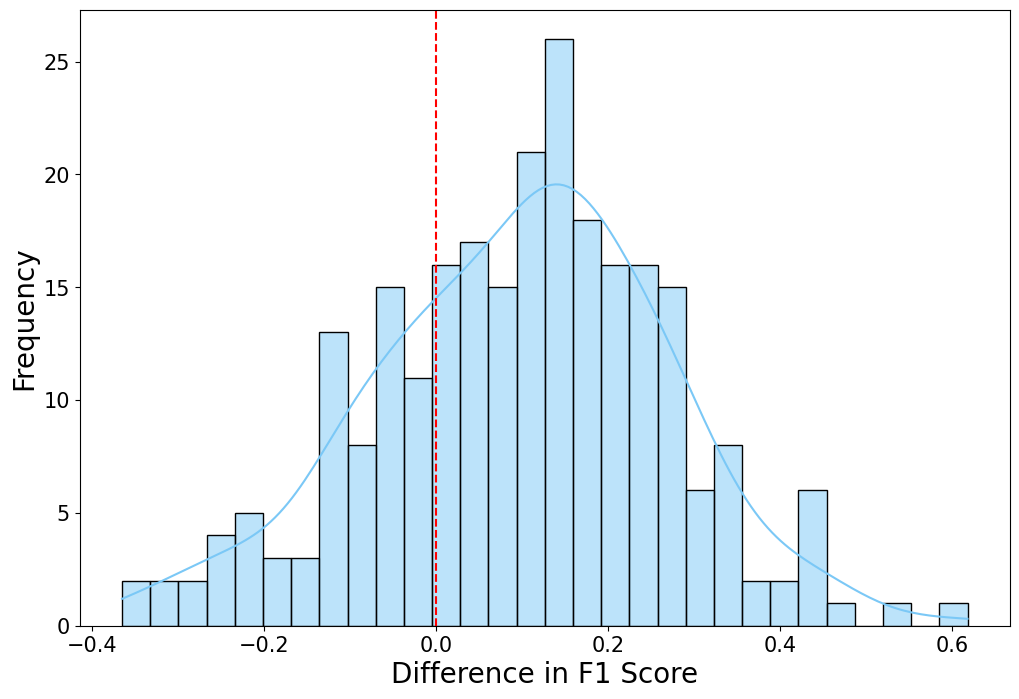

In [237]:
plt.figure(figsize=(12,8))
sns.histplot(metrics_compare['F1-score_diff'], bins=30, kde=True, color = '#7bc8f6')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Difference in F1 Score", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)

plt.tick_params(labelsize=15)
plt.savefig("../images/per_user_f1_diff.pdf",
                bbox_inches="tight", dpi=300)
plt.show()

# preparation for MLA

In [239]:
annotator_df['norm_text'] = annotator_df['text'].apply(normalize_text)


In [ ]:
df = annotator_df.copy()
df['text_id'] = pd.factorize(df['norm_text'])[0]

df['text_id'] = df['text_id'].apply(lambda x: f"txt_{x:04d}")
df

In [243]:
text_type_counts = df.groupby('norm_text')['text_type'].nunique()

matched_norm_texts = text_type_counts[text_type_counts == 2].index

df_matched = df[df['norm_text'].isin(matched_norm_texts)].copy()


In [245]:
ml_df = df_matched[['user_id', 'text_id', 'text_type', 'Human_Correct', 'true_label', 'Leia_Correct']]

ml_df = ml_df.rename(columns={
    'text_type': 'LEIA_condition',
    'Human_Correct': 'success', 'true_label': 'emotion'
})

ml_df['LEIA_shown'] = (ml_df['LEIA_condition'] == 'leia').astype(int)


In [247]:
ml_df.to_csv("mla_study_data_exp2.csv", index=False)


In [314]:

posterior_df = pd.read_csv("posterior_draws_exp2.csv")
posterior_df




,b_Intercept,b_LEIA_shown,sd_text_id__Intercept,sd_user_id__Intercept,Intercept,"r_text_id[txt_0000,Intercept]","r_text_id[txt_0001,Intercept]","r_text_id[txt_0002,Intercept]","r_text_id[txt_0003,Intercept]","r_text_id[txt_0004,Intercept]",...,"r_user_id[684ba9fb10c0b15054fbff59,Intercept]","r_user_id[684e146127b7a74fc6623b76,Intercept]","r_user_id[68530be0d3285cea014a57ed,Intercept]","r_user_id[6853e954cc44a6e6ea1c99b2,Intercept]","r_user_id[6853fdceead9f12c12bdce06,Intercept]",lprior,lp__,.chain,.iteration,.draw
0,1.152955,0.918242,3.114733,0.354141,1.612076,0.572412,2.325379,-4.440056,2.345290,-1.537894,...,-0.467406,0.063447,-0.269842,0.396010,-0.365526,-5.472199,-5011.728801,1,1,1
1,0.934540,0.927776,3.069536,0.333088,1.398428,0.670968,1.760151,-3.833074,1.435126,-1.038374,...,-0.210548,0.331491,-0.383375,0.649423,-0.291870,-5.389738,-4955.425897,1,2,2
2,1.034031,0.934119,3.014072,0.362932,1.501090,0.293264,1.749538,-3.430342,1.319893,-0.483082,...,-0.356872,0.214414,-0.423089,0.538697,-0.304309,-5.396389,-4960.718631,1,3,3
3,1.109133,0.909817,3.085087,0.291780,1.564041,1.082861,3.012945,-4.803294,1.308747,-1.694078,...,0.055937,-0.230234,-0.177279,0.192236,0.016380,-5.440620,-5053.141442,1,4,4
4,1.125850,0.797096,3.034401,0.356278,1.524397,1.293543,2.157785,-3.551181,5.000074,-2.526982,...,-0.162184,-0.127394,-0.256626,-0.206283,0.126744,-5.411401,-4980.898616,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.929299,0.784859,2.713803,0.260964,1.321728,1.525533,1.427683,-4.774757,2.061826,-2.662527,...,-0.504250,0.213373,0.149659,0.261652,-0.332770,-5.213273,-5065.478555,4,996,3996
3996,1.064980,0.944819,2.997145,0.299950,1.537389,-0.865173,3.215730,-2.839052,5.641032,-1.651082,...,0.085918,-0.438325,-0.607803,-0.315096,0.382061,-5.395112,-5019.298175,4,997,3997
3997,1.261520,0.761680,3.042228,0.260520,1.642360,0.795760,3.253091,-3.650956,5.949546,-2.486549,...,-0.216614,0.453046,-0.242461,0.324847,-0.236841,-5.443675,-5028.299465,4,998,3998
3998,1.095710,0.764560,2.809019,0.248548,1.477990,0.858828,1.514499,-2.672488,6.132008,-2.449660,...,-0.084605,0.483408,-0.056311,0.332782,-0.167388,-5.294712,-5084.579330,4,999,3999


In [249]:
# Extract draws for intercept and LEIA effect
intercept_draws = posterior_df["b_Intercept"]
leia_draws = posterior_df["b_LEIA_shown"]

def summarize(draws):
    return {
        "mean": np.mean(draws),
        "sd": np.std(draws),
        "2.5%": np.percentile(draws, 2.5),
        "97.5%": np.percentile(draws, 97.5)
    }

summary_intercept = summarize(intercept_draws)
summary_leia = summarize(leia_draws)


In [305]:
summary_leia

{'mean': 0.8522317034769353,
 'sd': 0.06503359917577096,
 '2.5%': 0.7248721774677949,
 '97.5%': 0.9824884175564921}

In [316]:
summary_intercept

{'mean': 1.1241239696697294,
 'sd': 0.11091545036131607,
 '2.5%': 0.9114533065471938,
 '97.5%': 1.3425614108008623}

In [318]:
# Calculate log-odds summaries
logodds_no_leia = posterior_df["b_Intercept"]
logodds_leia = posterior_df["b_Intercept"] + posterior_df["b_LEIA_shown"]

prob_no_leia = expit(logodds_no_leia)
prob_leia = expit(logodds_leia)

# Change in probability
prob_diff = prob_leia - prob_no_leia
mean_diff = prob_diff.mean()
ci_lower_diff = np.percentile(prob_diff, 2.5)
ci_upper_diff = np.percentile(prob_diff, 97.5)

summary = {
    "Condition": ["Intercept", "Intercept + LEIA shown"],
    "Log-odds [95% CI]": [
        f"{logodds_no_leia.mean():.2f} [{np.percentile(logodds_no_leia, 2.5):.2f}, {np.percentile(logodds_no_leia, 97.5):.2f}]",
        f"{logodds_leia.mean():.2f} [{np.percentile(logodds_leia, 2.5):.2f}, {np.percentile(logodds_leia, 97.5):.2f}]"
    ],
    "Probability [95% CI]": [
        f"{expit(logodds_no_leia.mean()):.2f} [{np.percentile(expit(logodds_no_leia), 2.5):.2f}, {np.percentile(expit(logodds_no_leia), 97.5):.2f}]",
        f"{expit(logodds_leia.mean()):.2f} [{np.percentile(expit(logodds_leia), 2.5):.2f}, {np.percentile(expit(logodds_leia), 97.5):.2f}]"
    ],
    "Change in Probability": [
        "-",
        f"{mean_diff:.2f} [{ci_lower_diff:.2f}, {ci_upper_diff:.2f}]"
    ]
}

summary_df = pd.DataFrame(summary)
summary_df

,Condition,Log-odds [95% CI],Probability [95% CI],Change in Probability
0,Intercept,"1.12 [0.91, 1.34]","0.75 [0.71, 0.79]",-
1,Intercept + LEIA shown,"1.98 [1.76, 2.21]","0.88 [0.85, 0.90]","0.12 [0.10, 0.15]"


In [252]:
text_sd = posterior_df["sd_text_id__Intercept"]
user_sd = posterior_df["sd_user_id__Intercept"]

print(f"\nText variability (SD): mean = {np.mean(text_sd):.2f}")
print(f"User variability (SD): mean = {np.mean(user_sd):.2f}")



Text variability (SD): mean = 2.97
User variability (SD): mean = 0.29


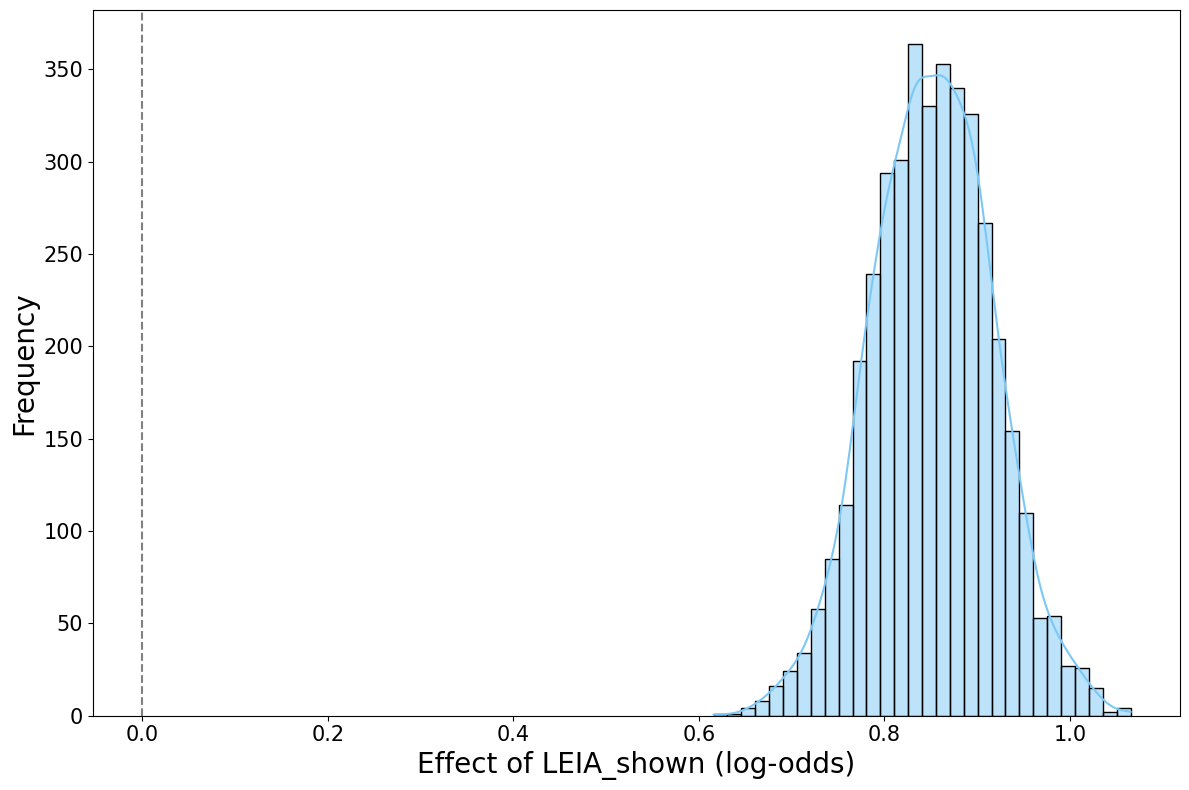

In [269]:

plt.figure(figsize=(12,8))
sns.histplot(posterior_df["b_LEIA_shown"], bins=30, kde=True, color="#7bc8f6")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel("Effect of LEIA_shown (log-odds)", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.savefig("../images/leia_shown_log_odds_dist.pdf",
                bbox_inches="tight", dpi=300)
plt.tight_layout()
plt.show()


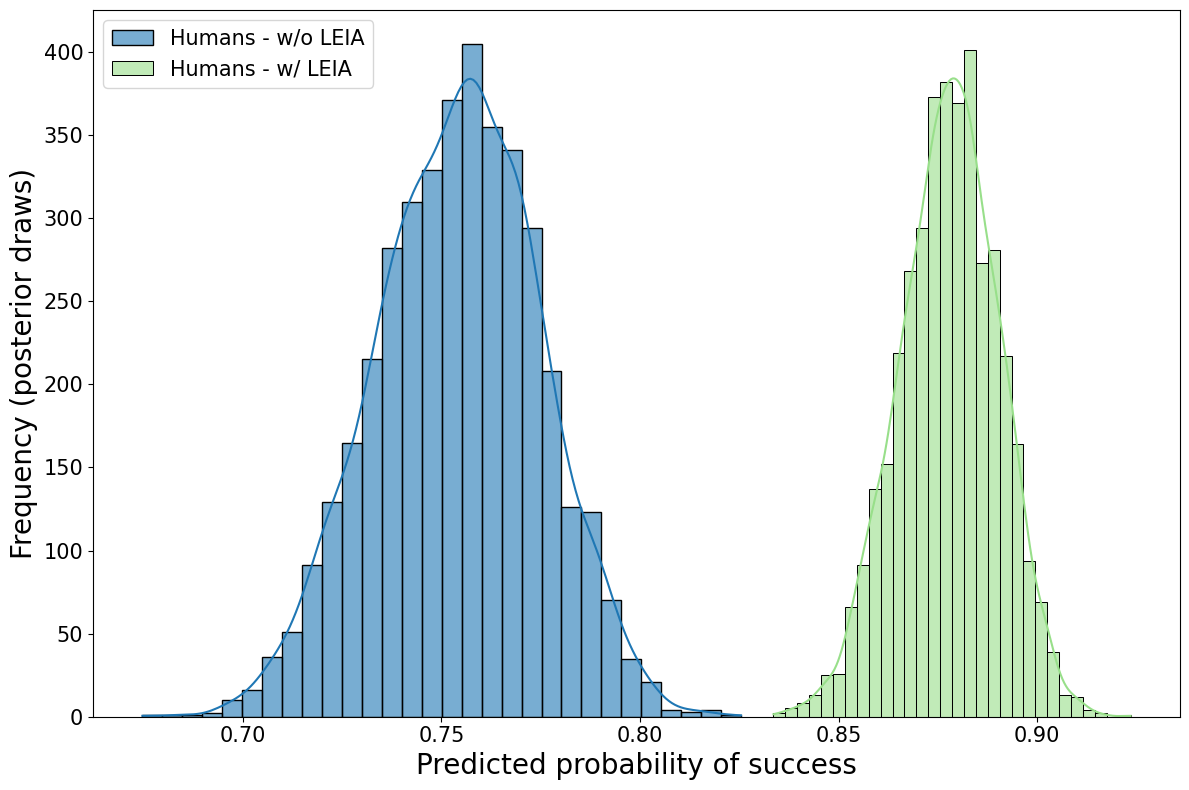

In [319]:
plt.figure(figsize=(12, 8))
sns.histplot(prob_no_leia, bins=30, alpha=0.6, kde=True, label='Humans - w/o LEIA', color = group_base_colors['Humans - w/o LEIA'])
sns.histplot(prob_leia, bins=30, alpha=0.6, kde=True, label='Humans - w/ LEIA', color = group_base_colors['Humans - w/ LEIA'])
plt.xlabel("Predicted probability of success", fontsize = 20)
plt.ylabel("Frequency (posterior draws)", fontsize = 20)
plt.tick_params(labelsize=15)
plt.legend(fontsize = 15)
plt.tight_layout()
plt.savefig("../images/leia_shown_prob_success_dist.pdf",
                bbox_inches="tight", dpi=300)
plt.show()


# including emotions

In [275]:


posterior_emotion = pd.read_csv("posterior_draws_emotion_exp2.csv")


In [277]:


# Calculate LEIA effect per emotion
posterior_emotion["LEIA_Happiness"] = posterior_emotion["b_LEIA_shown"]  # Anger is baseline
posterior_emotion["LEIA_Fear"] = posterior_emotion["b_LEIA_shown"] + posterior_emotion["b_LEIA_shown:emotionFear"]
posterior_emotion["LEIA_Anger"] = posterior_emotion["b_LEIA_shown"] + posterior_emotion["b_LEIA_shown:emotionAnger"]
posterior_emotion["LEIA_Sadness"] = posterior_emotion["b_LEIA_shown"] + posterior_emotion["b_LEIA_shown:emotionSadness"]


In [280]:
interaction_cols = [col for col in posterior_emotion.columns if 'b_LEIA_shown:emotion' in col]
emotions = [col.split(':emotion')[-1] for col in interaction_cols]
baseline_emotion = 'Happiness' 


In [282]:
emotion_results = {}

for emo in emotions:
    emo_main = posterior_emotion.get(f"b_emotion{emo}", 0) 
    leia_interaction = posterior_emotion.get(f"b_LEIA_shown:emotion{emo}", 0)
    
    logit_no = posterior_emotion['b_Intercept'] + emo_main
    logit_yes = posterior_emotion['b_Intercept'] + emo_main + posterior_emotion['b_LEIA_shown'] + leia_interaction
    
    p_no = expit(logit_no)
    p_yes = expit(logit_yes)
    
    emotion_results[emo] = {
        'p_no': p_no,
        'p_yes': p_yes,
        'delta': p_yes - p_no
    }

# Add baseline emotion 
emo = baseline_emotion
logit_no = posterior_emotion['b_Intercept']
logit_yes = posterior_emotion['b_Intercept'] + posterior_emotion['b_LEIA_shown']

p_no = expit(logit_no)
p_yes = expit(logit_yes)

emotion_results[emo] = {
    'p_no': p_no,
    'p_yes': p_yes,
    'delta': p_yes - p_no
}


In [283]:
summary = {
    emo: {
        'mean_prob_no': np.mean(res['p_no']),
        'mean_prob_yes': np.mean(res['p_yes']),
        'mean_delta': np.mean(res['delta']),
        'ci_2.5%': np.percentile(res['delta'], 2.5),
        'ci_97.5%': np.percentile(res['delta'], 97.5)
    }
    for emo, res in emotion_results.items()
}

summary_df = pd.DataFrame(summary).T.sort_values('mean_delta', ascending=False)
summary_df


,mean_prob_no,mean_prob_yes,mean_delta,ci_2.5%,ci_97.5%
Fear,0.339782,0.599052,0.259269,0.205593,0.311518
Anger,0.652981,0.827916,0.174935,0.123425,0.228743
Sadness,0.755452,0.865819,0.110367,0.070363,0.154220
Happiness,0.978276,0.984849,0.006573,0.000301,0.014595


In [ ]:

# Create summary table per emotion
emotion_summary = []

for emo, res in emotion_results.items():
    logit_no = np.log(res['p_no'] / (1 - res['p_no']))
    logit_yes = np.log(res['p_yes'] / (1 - res['p_yes']))
    
    mean_logit_no = np.mean(logit_no)
    mean_logit_yes = np.mean(logit_yes)
    ci_logit_no = np.percentile(logit_no, [2.5, 97.5])
    ci_logit_yes = np.percentile(logit_yes, [2.5, 97.5])
    
    mean_prob_no = np.mean(res['p_no'])
    mean_prob_yes = np.mean(res['p_yes'])
    ci_prob_no = np.percentile(res['p_no'], [2.5, 97.5])
    ci_prob_yes = np.percentile(res['p_yes'], [2.5, 97.5])
    
    mean_delta = np.mean(res['delta'])
    ci_delta = np.percentile(res['delta'], [2.5, 97.5])
    
    emotion_summary.append({
        'Emotion': emo,
        'Log-odds [95% CI] (No LEIA)': f"{mean_logit_no:.2f} [{ci_logit_no[0]:.2f}, {ci_logit_no[1]:.2f}]",
        'Log-odds [95% CI] (LEIA shown)': f"{mean_logit_yes:.2f} [{ci_logit_yes[0]:.2f}, {ci_logit_yes[1]:.2f}]",
        'Probability [95% CI] (No LEIA)': f"{mean_prob_no:.2f} [{ci_prob_no[0]:.2f}, {ci_prob_no[1]:.2f}]",
        'Probability [95% CI] (LEIA shown)': f"{mean_prob_yes:.2f} [{ci_prob_yes[0]:.2f}, {ci_prob_yes[1]:.2f}]",
        'Change in Probability [95% CI]': f"{mean_delta:.2f} [{ci_delta[0]:.2f}, {ci_delta[1]:.2f}]"
    })

emotion_summary_df = pd.DataFrame(emotion_summary).sort_values("Emotion")

emotion_summary_df

,Emotion,Log-odds [95% CI] (No LEIA),Log-odds [95% CI] (LEIA shown),Probability [95% CI] (No LEIA),Probability [95% CI] (LEIA shown),Change in Probability [95% CI]
0,Anger,"0.64 [0.27, 1.02]","1.58 [1.18, 1.99]","0.65 [0.57, 0.74]","0.83 [0.77, 0.88]","0.17 [0.12, 0.23]"
1,Fear,"-0.67 [-1.07, -0.29]","0.41 [0.01, 0.79]","0.34 [0.26, 0.43]","0.60 [0.50, 0.69]","0.26 [0.21, 0.31]"
3,Happiness,"3.84 [3.34, 4.33]","4.21 [3.69, 4.73]","0.98 [0.97, 0.99]","0.98 [0.98, 0.99]","0.01 [0.00, 0.01]"
2,Sadness,"1.14 [0.75, 1.54]","1.88 [1.48, 2.29]","0.76 [0.68, 0.82]","0.87 [0.81, 0.91]","0.11 [0.07, 0.15]"


In [326]:

structured_rows = []

for row in emotion_summary:
    emotion = row['Emotion']
    
    # Row for No LEIA
    structured_rows.append({
        'Emotion': emotion,
        'Condition': 'No LEIA',
        'Log-odds [95% CI]': row['Log-odds [95% CI] (No LEIA)'],
        'Probability [95% CI]': row['Probability [95% CI] (No LEIA)'],
        'Change in Probability': '-'
    })
    
    # Row for LEIA shown
    structured_rows.append({
        'Emotion': emotion,
        'Condition': 'LEIA shown',
        'Log-odds [95% CI]': row['Log-odds [95% CI] (LEIA shown)'],
        'Probability [95% CI]': row['Probability [95% CI] (LEIA shown)'],
        'Change in Probability': row['Change in Probability [95% CI]']
    })

# Convert to DataFrame
structured_emotion_summary_df = pd.DataFrame(structured_rows)
structured_emotion_summary_df


,Emotion,Condition,Log-odds [95% CI],Probability [95% CI],Change in Probability
0,Anger,No LEIA,"0.64 [0.27, 1.02]","0.65 [0.57, 0.74]",-
1,Anger,LEIA shown,"1.58 [1.18, 1.99]","0.83 [0.77, 0.88]","0.17 [0.12, 0.23]"
2,Fear,No LEIA,"-0.67 [-1.07, -0.29]","0.34 [0.26, 0.43]",-
3,Fear,LEIA shown,"0.41 [0.01, 0.79]","0.60 [0.50, 0.69]","0.26 [0.21, 0.31]"
4,Sadness,No LEIA,"1.14 [0.75, 1.54]","0.76 [0.68, 0.82]",-
5,Sadness,LEIA shown,"1.88 [1.48, 2.29]","0.87 [0.81, 0.91]","0.11 [0.07, 0.15]"
6,Happiness,No LEIA,"3.84 [3.34, 4.33]","0.98 [0.97, 0.99]",-
7,Happiness,LEIA shown,"4.21 [3.69, 4.73]","0.98 [0.98, 0.99]","0.01 [0.00, 0.01]"


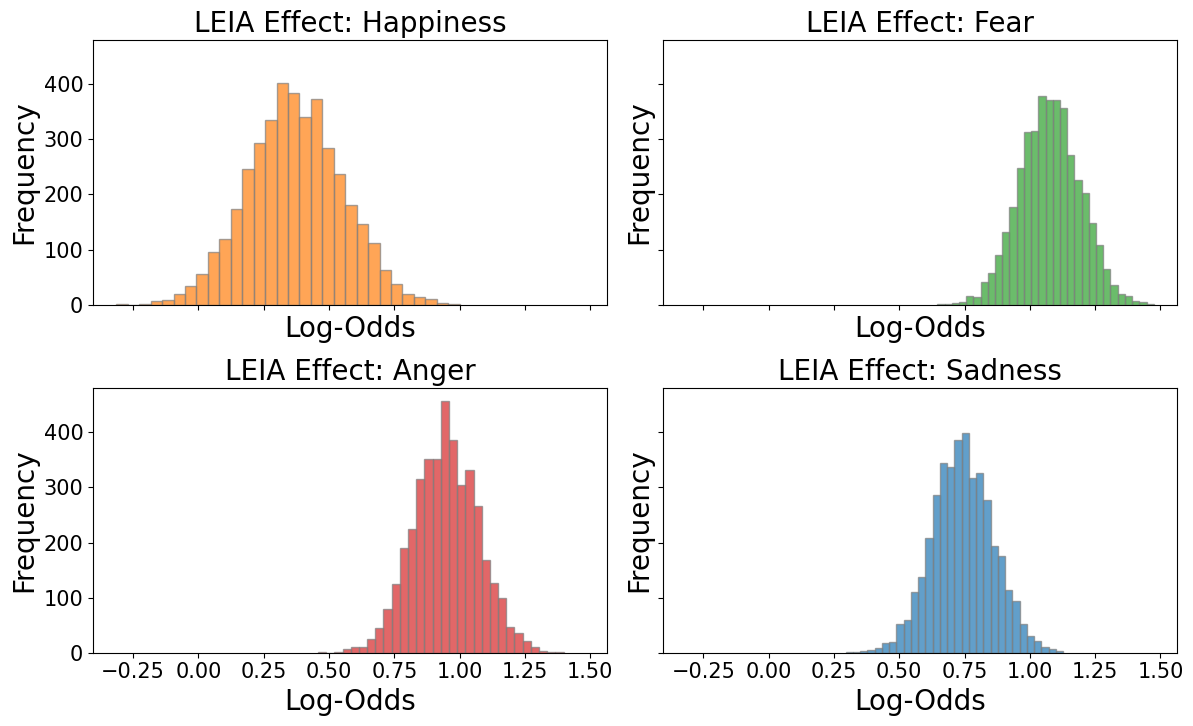

In [295]:

# Define the emotion-specific LEIA effect columns and their colors
emotion_effects = {
    'Happiness': 'LEIA_Happiness',
    'Fear': 'LEIA_Fear',
    'Anger': 'LEIA_Anger',
    'Sadness': 'LEIA_Sadness'
}

colors = {
    'Anger': '#d62728',
    'Fear': '#2ca02c',
    'Happiness': '#ff7f0e',
    'Sadness': '#1f77b4'
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot histograms
for i, (emotion, column) in enumerate(emotion_effects.items()):
    ax = axes[i]
    ax.hist(posterior_emotion[column], bins=30, color=colors[emotion], alpha=0.7, edgecolor = 'gray')
    ax.set_title(f"LEIA Effect: {emotion}", fontsize = 20)
    ax.set_xlabel("Log-Odds", fontsize = 20)
    ax.set_ylabel("Frequency", fontsize = 20)
    ax.tick_params(labelsize = 15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../images/leia_shown_log_odds_dist-emotion.pdf",
                bbox_inches="tight", dpi=300)
plt.show()


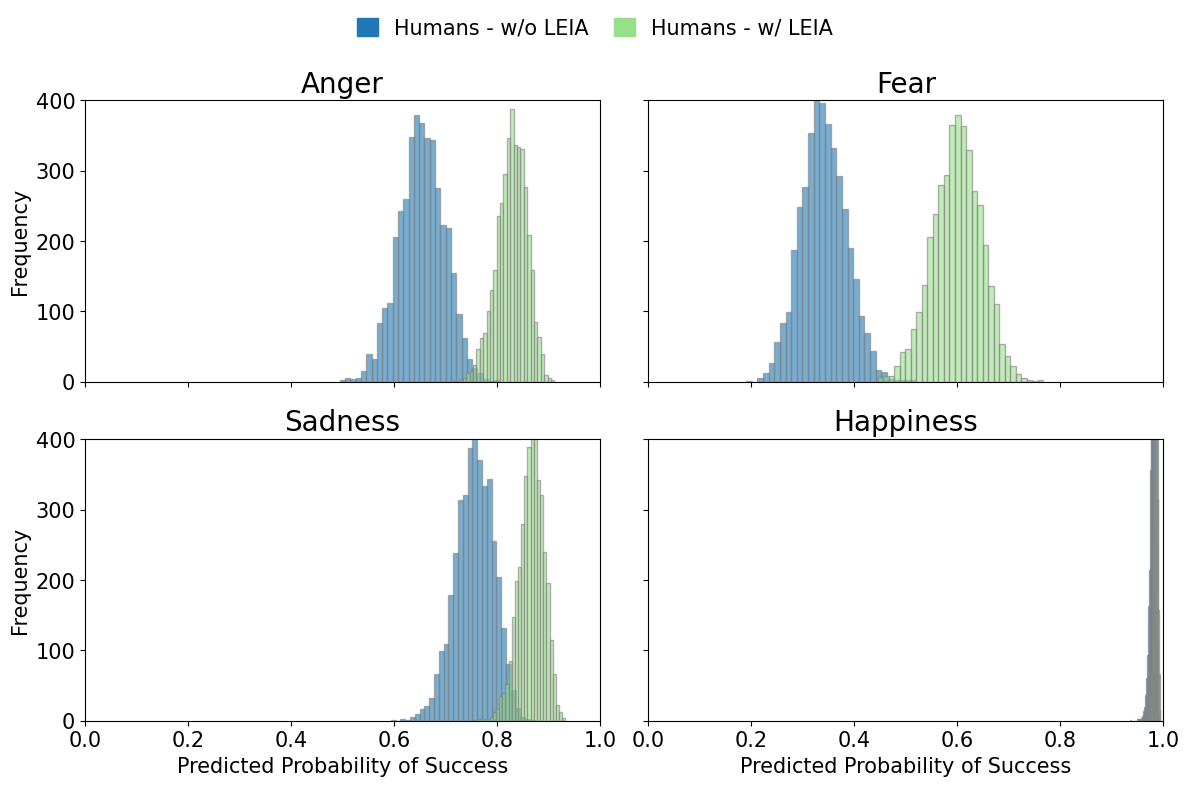

In [304]:

emotions = list(emotion_results.keys())
n_emotions = len(emotions)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, emo in enumerate(emotions):
    ax = axes[i]
    p_no = emotion_results[emo]['p_no']
    p_yes = emotion_results[emo]['p_yes']

    ax.hist(p_no, bins=30, alpha=0.6, label='LEIA not shown', color=group_base_colors['Humans - w/o LEIA'], edgecolor='gray')
    ax.hist(p_yes, bins=30, alpha=0.6, label='LEIA shown', color=group_base_colors['Humans - w/ LEIA'], edgecolor='gray')
    
    ax.set_title(f"{emo}", fontsize = 20)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, max(len(p_no) // 10, 100))
    ax.tick_params(labelsize=15)
    if i % 2 == 0:
        ax.set_ylabel("Frequency", fontsize = 15)
    if i >= 2:
        ax.set_xlabel("Predicted Probability of Success", fontsize = 15)


legend_handles = [
    mpatches.Patch( label='Humans - w/o LEIA', color = group_base_colors['Humans - w/o LEIA']),
    mpatches.Patch( label='Humans - w/ LEIA', color = group_base_colors['Humans - w/ LEIA'])
]

fig.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    frameon=False,
    handlelength=1.0,
    handleheight=1.0,
    columnspacing=1.2,
    borderpad=0.4,
    fontsize=15
)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../images/leia_shown_prob_success_dist-emotion.pdf",
                bbox_inches="tight", dpi=300)
plt.show()
